In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tüfe=pd.read_csv("tüfe.csv",index_col=0)
tüfe.index=pd.to_datetime(tüfe.index)
endeksler=pd.read_csv("endeksler.csv",index_col=0)
harcama_grupları=pd.read_csv("harcama_grupları.csv",index_col=0)
harcama_grupları.index=pd.to_datetime(harcama_grupları.index)
özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özel=pd.read_excel("özel.xlsx")
cols=özel.iloc[3,:]
özel=özel.iloc[4:,:]
özel.columns=["Kod", "Grup", "EN", "Ağırlık", '1.Alt Gösterge', '2.Orta Gösterge',
       '3.Üst Gösterge', np.nan, np.nan, np.nan, '4.En Üst Gösterge', np.nan, np.nan,
       '5.TÜFE A', np.nan, np.nan, '6.TÜFE B', np.nan, np.nan, '7.TÜFE C', np.nan, np.nan,
       '8.TÜFE D', np.nan, np.nan, '9.TÜFE E', np.nan, np.nan, '10.TÜFE F']

In [2]:
data=pd.read_excel("C:/Users/Bora/Documents/GitHub/Enflasyon-SATRIM/harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))

ağırlık=pd.read_excel("C:/Users/Bora/Documents/GitHub/Enflasyon-SATRIM/tuketici fiyat endeksi ana grup ve temel baslik agirliklari2025.xls")


ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
data=data[harcama_grupları.columns].loc["2016-12-31":]
data.loc[pd.to_datetime("2025-03-31")]=(harcama_grupları.loc["2025-03"].mean()/harcama_grupları.loc["2025-02-01":"2025-02-24"].mean())*data.loc[pd.to_datetime("2025-02-28")]
data=data.sort_index()
from scipy import interpolate

for col in data.isna().sum().sort_values().index[-2:].values:

    valid_data = data[col].dropna()

    # x (geçerli tarihlerin indeksleri) ve y (geçerli değerler) verilerini alıyoruz
    x = np.array((valid_data.index - valid_data.index.min()).days)  # Gün cinsinden
    y = valid_data.values

    # Lineer interpolasyon fonksiyonu oluşturuyoruz
    interp_func = interpolate.interp1d(x, y, fill_value='extrapolate')

    # Tüm tarihleri kullanarak NaN değerlerini dolduruyoruz
    all_x = np.array((data[col].index - valid_data.index.min()).days)  # Tüm tarihlerin gün cinsinden indeksleri
    data[col] = interp_func(all_x)

In [ ]:

işlenmemiş=özel[özel["2.Orta Gösterge"]=="İşlenmemiş gıda"].groupby("1.Alt Gösterge")["Ağırlık"].sum()/özel[özel["2.Orta Gösterge"]=="İşlenmemiş gıda"].groupby("1.Alt Gösterge")["Ağırlık"].sum().sum()
gıda=özel[özel["3.Üst Gösterge"]=="Gıda ve alkolsüz içecekler"].groupby("2.Orta Gösterge")["Ağırlık"].sum()/özel[özel["3.Üst Gösterge"]=="Gıda ve alkolsüz içecekler"].groupby("2.Orta Gösterge")["Ağırlık"].sum().sum()
temel=özel[özel["2.Orta Gösterge"]=="Temel mallar"].groupby("1.Alt Gösterge")["Ağırlık"].sum()/özel[özel["2.Orta Gösterge"]=="Temel mallar"].groupby("1.Alt Gösterge")["Ağırlık"].sum().sum()
enerjivegıdadışımallar=özel[özel["3.Üst Gösterge"]=="Enerji ve gıda dışı mallar"].groupby("2.Orta Gösterge")["Ağırlık"].sum()/özel[özel["3.Üst Gösterge"]=="Enerji ve gıda dışı mallar"].groupby("2.Orta Gösterge")["Ağırlık"].sum().sum()

In [4]:
cols=pd.read_excel("EVDS (2).xlsx").columns[1:].values
cols=[s.replace(" ", ".") for s in cols]

In [7]:
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
import warnings
from datetime import date
warnings.filterwarnings("ignore")
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-12-2016",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])
   

    return seri
    

series_list=cols
data=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    data=pd.concat([data,veri],axis=1)


tarih=data.iloc[:,0]



data=data.set_index(pd.date_range(start="2016-12-31",freq="M",periods=len(data)))
del data["Tarih"]
#data=data.dropna()
for col in data.columns:
    data[col]=data[col].astype(float)

In [8]:
data.columns=["Mevsimlik Ürünler Hariç TÜFE",'TÜFE B', 'TÜFE C', 'TÜFE D','TÜFE E', 'TÜFE F','Mallar', 'Enerji', 'Gıda ve alkolsüz içecekler',
       'İşlenmemiş gıda','Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmiş Gıda','Ekmek ve tahıllar','Diğer işlenmiş gıda','Enerji ve gıda dışı mallar', 'Temel mallar', 'Giyim ve ayakkabı',
       'Dayanıklı Mallar (altın hariç)', 'Diğer Temel Mallar',
       'Alkollü içecekler, tütün ve altın', 'Hizmet', 'Kira',
       'Lokanta ve oteller', 'Ulaştırma hizmetleri', 'Haberleşme hizmetleri',
       'Diğer hizmetler']
data=data[özelgöstergeler.columns]

In [9]:
data.loc["2025-03-31"]=(data.loc["2025-02-28"]*(özelgöstergeler.loc["2025-03"].mean()/özelgöstergeler.loc["2025-02-01":"2025-02-24"].mean())).values

In [23]:
datasa = pd.DataFrame()

In [91]:
import os
import random
import numpy as np
import pandas as pd
from statsmodels.tsa.x13 import x13_arima_analysis

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)



# Set the path to the X13-ARIMA executable
x13_path = r'C:\Users\Bora\Desktop\x13as'
spec = """
outlier {
    method = addone;
    types = ao tc ls;
}
"""





ayris = x13_arima_analysis(np.log(data["Taze meyve ve sebze"]), x12path=x13_path,outlier=True,maxorder=(0,1,1),maxdiff=(0,1,1))
datasa["Taze meyve ve sebze"] = np.exp(ayris.seasadj)

ayris = x13_arima_analysis(np.log(data["Diğer işlenmemiş gıda"]), x12path=x13_path,outlier=True,maxorder=(0,1,1),maxdiff=(0,1,1))
datasa["Diğer işlenmemiş gıda"] = np.exp(ayris.seasadj)

ayris = x13_arima_analysis(np.log(data["Giyim ve ayakkabı"]), x12path=x13_path,outlier=True,maxorder=(0,1,1),maxdiff=(0,1,1))
datasa["Giyim ve ayakkabı"] = np.exp(ayris.seasadj)

ayris = x13_arima_analysis(np.log(data["Kira"]), x12path=x13_path,outlier=True,maxorder=(0,1,1),maxdiff=(0,2,0))
datasa["Kira"] = np.exp(ayris.seasadj)



X13Error: Line  114:  maxdiff = (0 2)
                           ^
 ERROR:  Maximum order of seasonal differencing must be less than or equal to 
         1.

In [86]:
datasa["İşlenmemiş gıda"]=(datasa[işlenmemiş.index]*işlenmemiş).sum(axis=1)
datasa["İşlenmiş Gıda"]=data["İşlenmiş Gıda"]
gıda.index=["İşlenmemiş gıda","İşlenmiş Gıda"]
datasa["Gıda ve alkolsüz içecekler"]=(datasa[gıda.index]*gıda).sum(axis=1)
datasa["Dayanıklı Mallar (altın hariç)"]=data["Dayanıklı Mallar (altın hariç)"]
datasa["Diğer Temel Mallar"]=data["Diğer Temel Mallar"]
temel.index=["Dayanıklı Mallar (altın hariç)","Diğer Temel Mallar","Giyim ve ayakkabı"]
datasa["Temel mallar"]=(datasa[temel.index]*temel).sum(axis=1)
datasa["Alkollü içecekler, tütün ve altın"]=data["Alkollü içecekler, tütün ve altın"]
datasa["Enerji ve gıda dışı mallar"]=(datasa[enerjivegıdadışımallar.index]*enerjivegıdadışımallar).sum(axis=1)

In [90]:
datasa["Kira"].pct_change()*100

2016-12-31 00:00:00         NaN
2017-01-31 00:00:00    0.620178
2017-02-28 00:00:00    0.717531
2017-03-31 00:00:00    0.687960
2017-04-30 00:00:00    0.690647
                         ...   
2024-11-30 00:00:00    4.897507
2024-12-31 00:00:00    4.500298
2025-01-31 00:00:00    8.422262
2025-02-28 00:00:00    4.509224
2025-03-31             3.824768
Name: Kira, Length: 100, dtype: float64

In [2]:

maddelerim=endeksler.T
maddelerim=maddelerim.reset_index()
maddelerim=maddelerim.rename(columns={"index":"Madde"})

In [3]:

def hareketli_aylik_ortalama(df):
        değer = df.name  # Kolon ismi
        df = pd.DataFrame(df)
        df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
        df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
        
        # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
        df["Aylık Ortalama"] = (
            df[df["Gün Sırası"] <= 24]
            .groupby(df["Tarih"].dt.to_period("M"))[değer]
            .expanding()
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        # Orijinal indeksi geri yükle
        df.index = pd.to_datetime(df.index)
        return df

In [4]:
tüfe=pd.read_csv("gruplar_int.csv",index_col=0)
tüfe.index=pd.to_datetime(tüfe.index)
tüfe=tüfe.sort_index()
harcama_grupları["TÜFE"]=tüfe["TÜFE"]





harcama_grupları.index=pd.to_datetime(harcama_grupları.index)
harcama_grupları=harcama_grupları.sort_index()
harcama_grupları_aylık=pd.DataFrame(columns=harcama_grupları.columns)
for col in harcama_grupları.columns:
    cari=hareketli_aylik_ortalama(harcama_grupları[col])["Aylık Ortalama"].fillna(method="ffill")
    harcama_grupları_aylık[col]=cari.resample('M').last().pct_change().loc["2025-02":]*100
    carim=hareketli_aylik_ortalama(harcama_grupları[col])["Aylık Ortalama"].fillna(method="ffill").loc[tarih:]
    hareketliartıs=carim.values/hareketli_aylik_ortalama(harcama_grupları[col])["Aylık Ortalama"].fillna(method="ffill").loc[f"{onceki}-24"]
    hareketliartıs=pd.Series(hareketliartıs,index=carim.index)
    hareketliartıs=(hareketliartıs-1)*100
    harcama_grupları_aylık[col].iloc[-1]=hareketliartıs.iloc[-1]
    harcama_grupları_aylık=pd.DataFrame(harcama_grupları_aylık)
harcama_grupları_aylık["Tarih"]=(harcama_grupları_aylık.index.strftime("%Y-%m"))




harcama_artıs=harcama_grupları_aylık[harcama_grupları_aylık["Tarih"]=="2025-02"].iloc[0]





harcama_artıs=harcama_artıs.drop("Tarih",axis=0).sort_values()

NameError: name 'tarih' is not defined

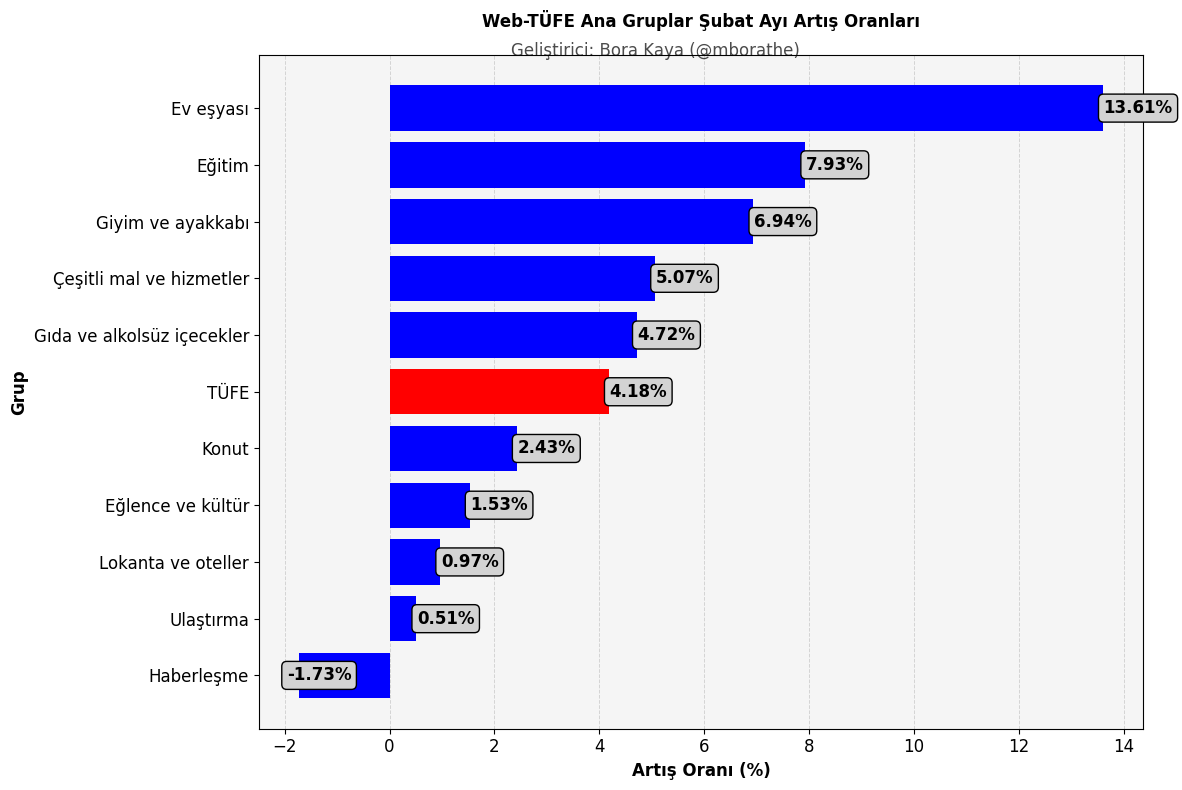

In [5]:
def hareketli_aylik_ortalama(df):
    
        değer = df.name  # Kolon ismi
        df = pd.DataFrame(df)
        df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
        df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
        
        # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
        df["Aylık Ortalama"] = (
            df[df["Gün Sırası"] <= 24]
            .groupby(df["Tarih"].dt.to_period("M"))[değer]
            .expanding()
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        # Orijinal indeksi geri yükle
        df.index = pd.to_datetime(df.index)
        return df

from datetime import datetime,timedelta
import pytz
tüfe=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe-streamlit/tüfe.csv",index_col=0)
tüfe.index=pd.to_datetime(tüfe.index)

gruplar=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe-streamlit/gruplar_int.csv",index_col=0)
gruplar.index=pd.to_datetime(gruplar.index)
gfe1=tüfe.copy()
gfe1["Date"]=pd.to_datetime(gfe1.index)
gfe1["Ay"]=gfe1["Date"].dt.month
gfe1["Yıl"]=gfe1["Date"].dt.year    
month = gfe1["Ay"].iloc[-1]
year=gfe1["Yıl"].iloc[-1] 
oncekiyear=gfe1["Yıl"].iloc[-1] 
tarihim=pd.to_datetime(gfe1.index[-1]).day
if tarihim>24:
    tarihim=24
if tarihim<10:
    tarihim="0"+str(tarihim)

from datetime import datetime,timedelta
tarih=datetime.now().strftime("%Y-%m")
onceki=(datetime.now()-timedelta(days=31)).strftime("%Y-%m")

harcama_artıs=pd.Series(index=gruplar.columns)
for col in gruplar.columns:
    harcama_artıs.loc[col]=(((hareketli_aylik_ortalama(gruplar[col])["Aylık Ortalama"].fillna(method="ffill").iloc[-1]/hareketli_aylik_ortalama(gruplar[col])["Aylık Ortalama"].fillna(method="ffill").loc[f"{onceki}-{tarihim}"])-1)*100)

harcama_artıs=harcama_artıs.sort_values()

colors = ['red' if label == 'TÜFE' else 'blue' for label in harcama_artıs.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:42] for label in harcama_artıs.index]



colors = ['red' if label == 'TÜFE' else 'blue' for label in harcama_artıs.keys()]
shortened_index = [label[:42] for label in harcama_artıs.keys()]
values = list(harcama_artıs)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +1,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.3')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Web-TÜFE Ana Gruplar Şubat Ayı Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=20)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Grup', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.55, 0.93, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()
plt.savefig("anagruplar.png", dpi=300)

plt.show()



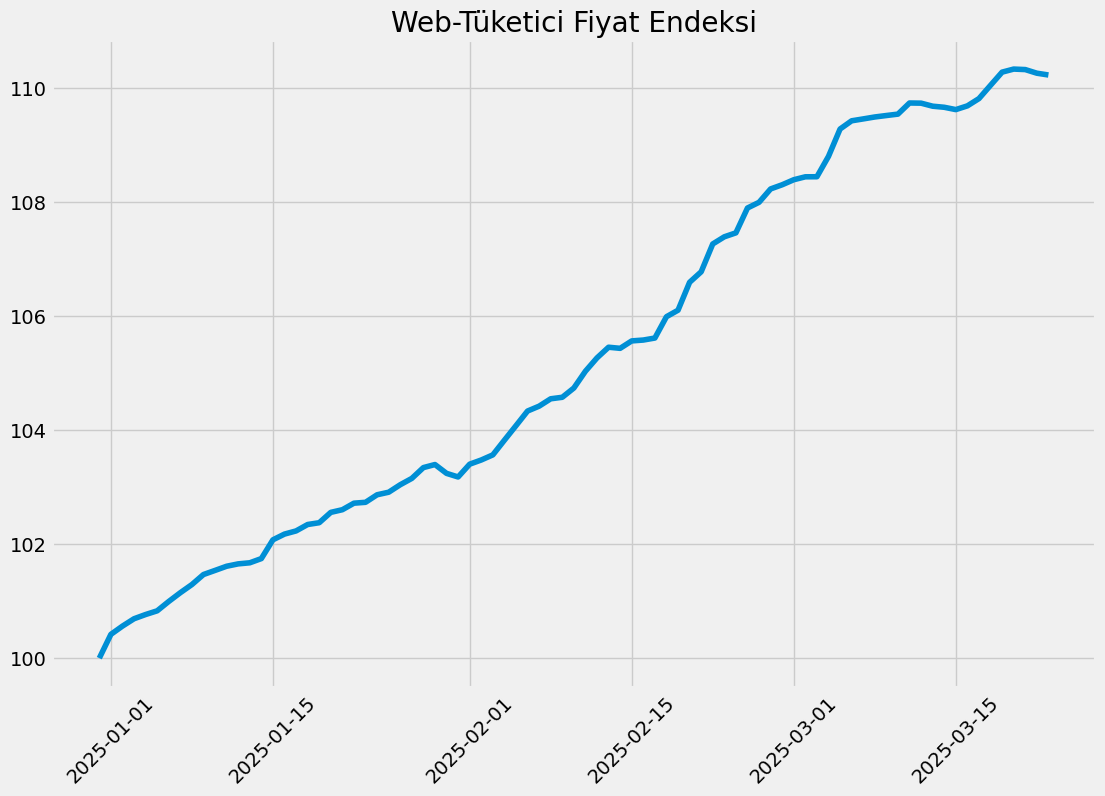

In [7]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.plot(tüfe,label="TÜFE")
plt.grid(True)
plt.xticks(rotation=45)
plt.title("Web-Tüketici Fiyat Endeksi")
plt.savefig("tüfe.png", dpi=300)

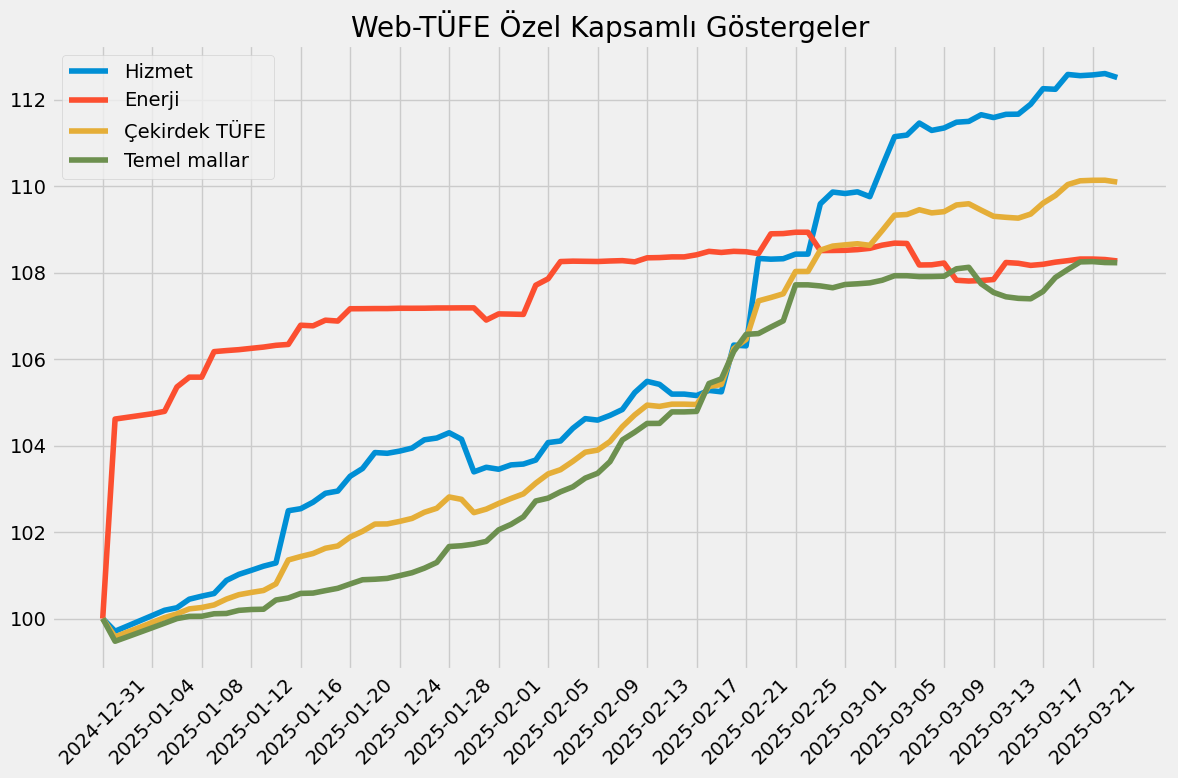

In [8]:
özelgöstergeler.loc[pd.to_datetime("2024-12-31")]=100
özelgöstergeler=özelgöstergeler.sort_index()
plt.figure(figsize=(12,8))
plt.title("Web-TÜFE Özel Kapsamlı Göstergeler")

plt.plot(özelgöstergeler["Hizmet"],label="Hizmet")
plt.plot(özelgöstergeler["Enerji"],label="Enerji")
plt.plot(özelgöstergeler["TÜFE C"],label="Çekirdek TÜFE")
plt.plot(özelgöstergeler["Temel mallar"],label="Temel mallar")
plt.legend()
plt.grid(True)
plt.xticks(özelgöstergeler.index[::4],rotation=45)
plt.tight_layout()
plt.savefig("özelgöstergeler.png", dpi=300)

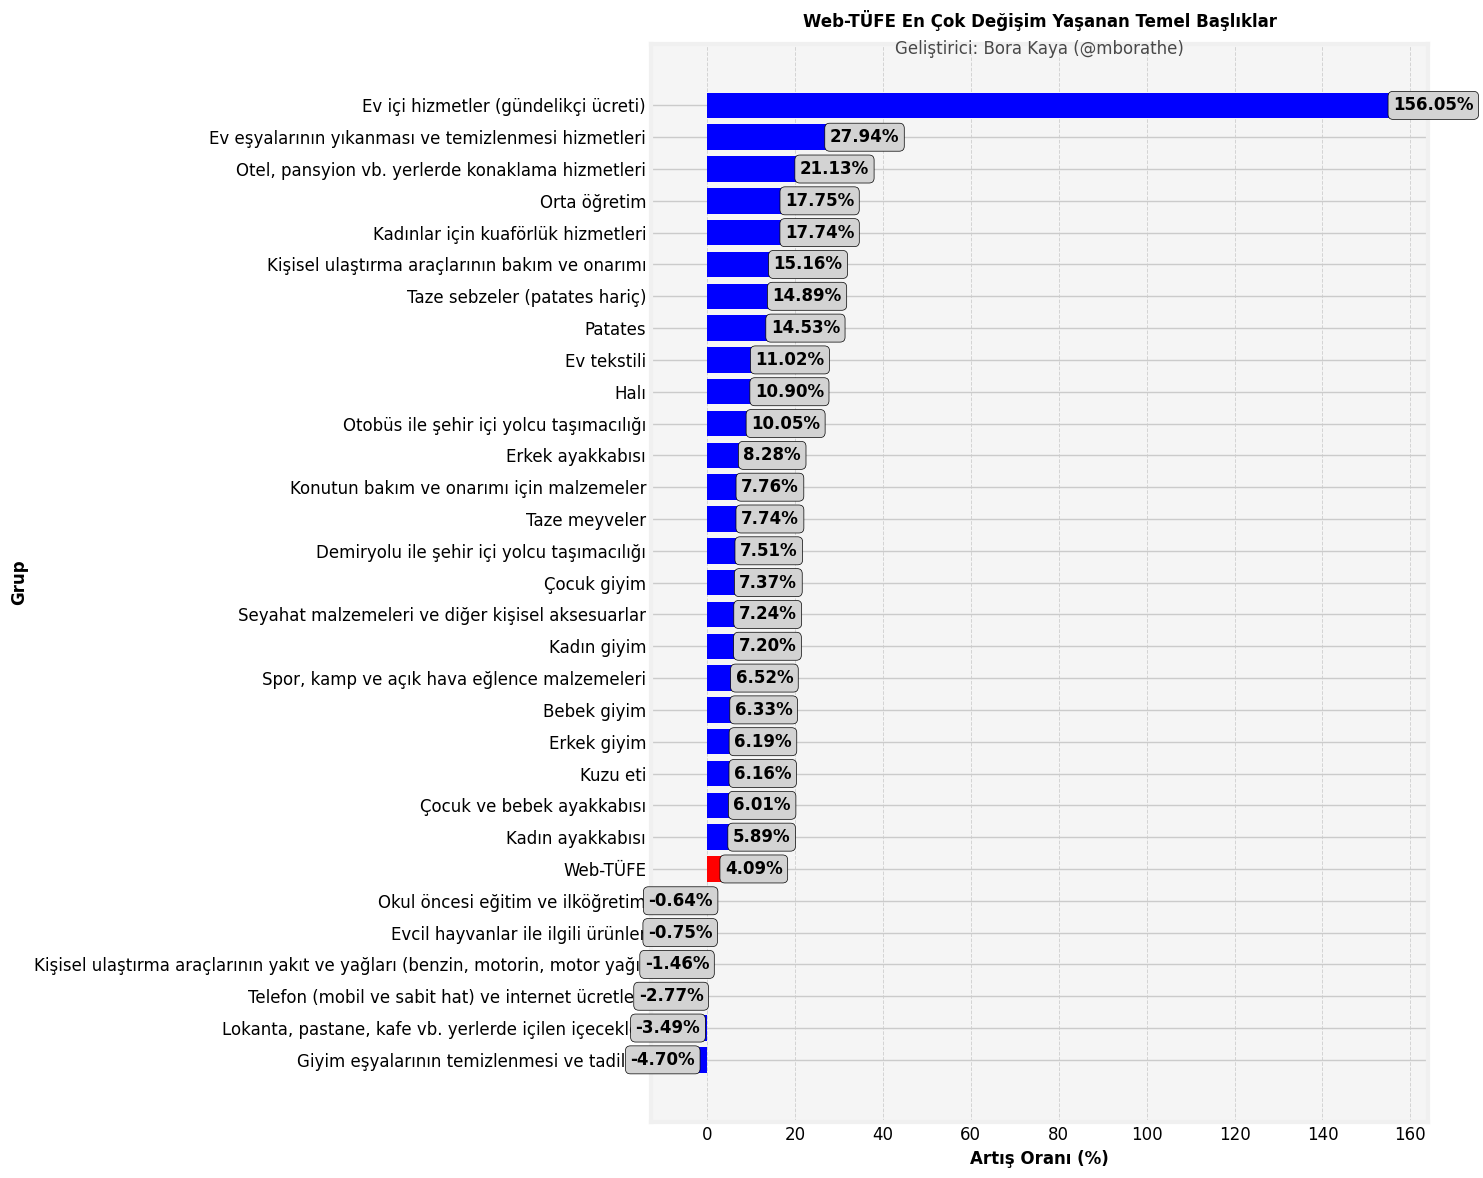

In [9]:
harcama_grupları=harcama_grupları.sort_index()
veri=pd.concat([(((harcama_grupları.loc["2025-03"].mean()/harcama_grupları.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().head(6),(((harcama_grupları.loc["2025-03"].mean()/harcama_grupları.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().tail(24)],axis=0)
veri.loc["Web-TÜFE"]=(((tüfe.loc["2025-03"].mean()/tüfe.loc["2025-02-01":"2025-02-24"].mean())-1)*100).values[0]
veri=veri.sort_values()

colors = ['red' if label == 'Web-TÜFE' else 'blue' for label in veri.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in veri.index]



shortened_index = [label[:100] for label in veri.keys()]
values = list(veri)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.3')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Web-TÜFE En Çok Değişim Yaşanan Temel Başlıklar', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Grup', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.7, 0.95, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig("temelbaşlıklar.png", dpi=300)



In [13]:
endeksler.index=pd.to_datetime(endeksler.index)

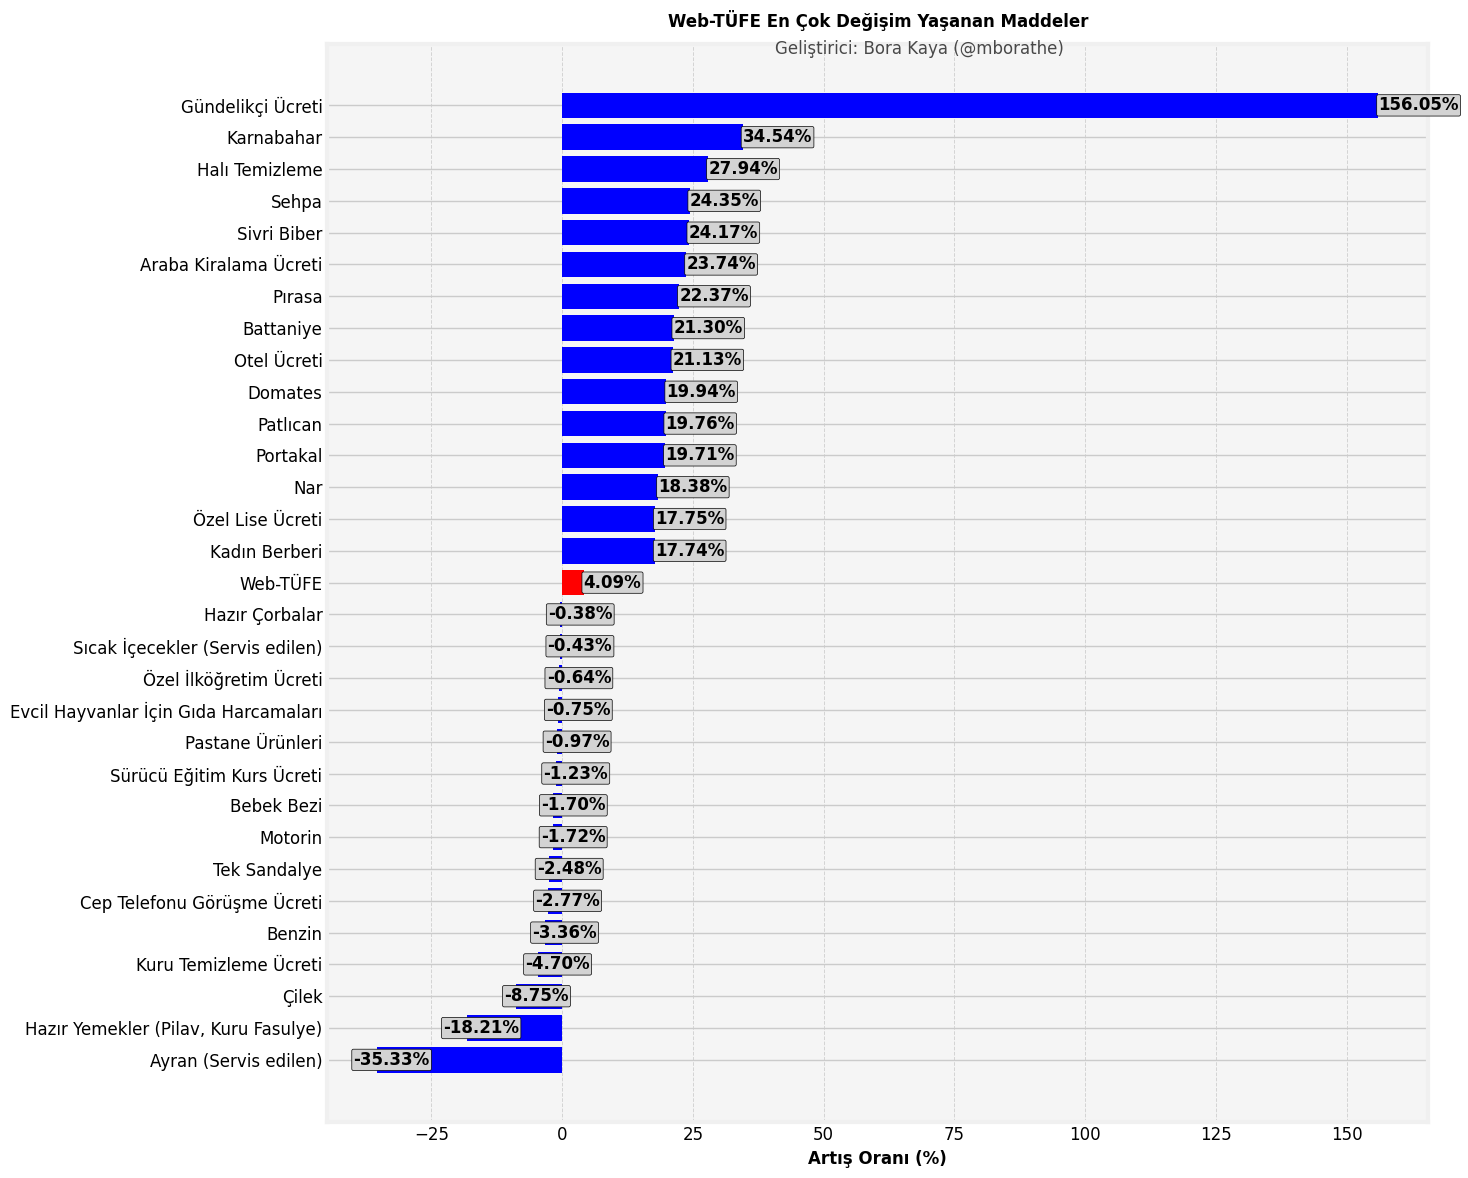

In [14]:
endeksler=endeksler.sort_index()
veri=pd.concat([(((endeksler.loc["2025-03"].mean()/endeksler.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().head(15),(((endeksler.loc["2025-03"].mean()/endeksler.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().tail(15)],axis=0)
veri.loc["Web-TÜFE"]=(((tüfe.loc["2025-03"].mean()/tüfe.loc["2025-02-01":"2025-02-24"].mean())-1)*100).values[0]
veri=veri.sort_values()

colors = ['red' if label == 'Web-TÜFE' else 'blue' for label in veri.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in veri.index]



shortened_index = [label[:100] for label in veri.keys()]
values = list(veri)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +10,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Web-TÜFE En Çok Değişim Yaşanan Maddeler', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.62, 0.95, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig("maddeler.png", dpi=300)



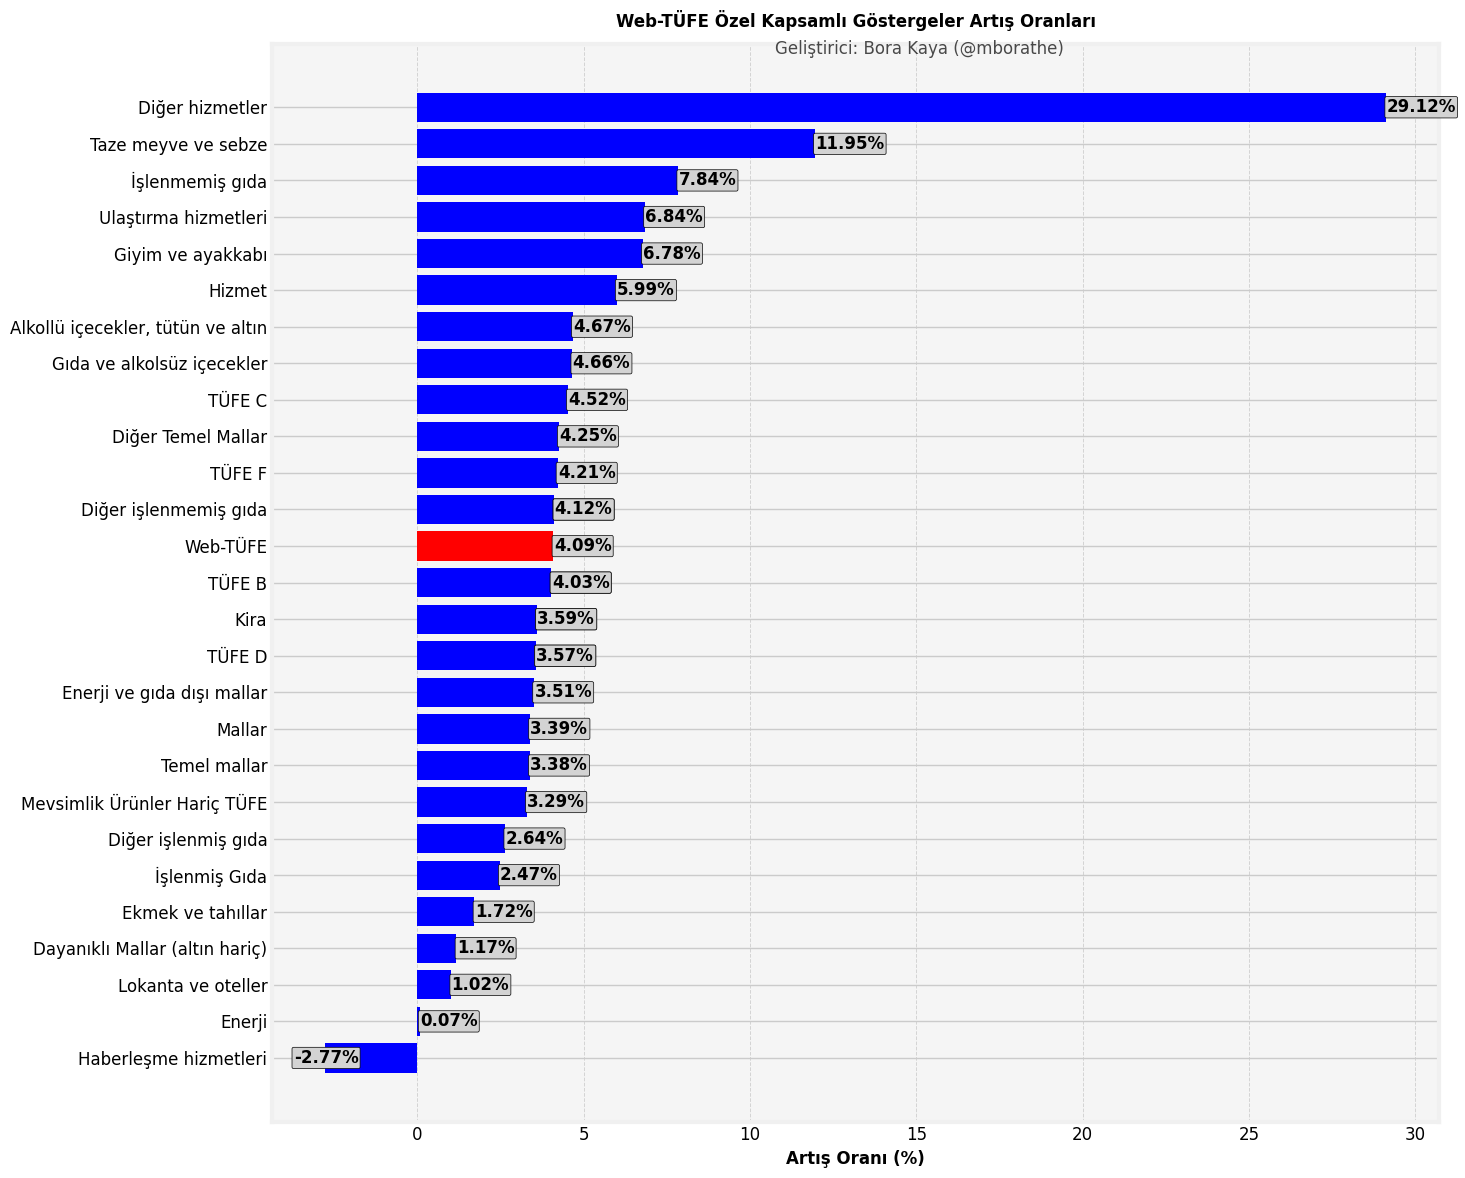

In [15]:
özelgöstergeler=özelgöstergeler.sort_index()
veri=pd.concat([(((özelgöstergeler.loc["2025-03"].mean()/özelgöstergeler.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().head(15),(((özelgöstergeler.loc["2025-03"].mean()/özelgöstergeler.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().tail(15)],axis=0)
veri.loc["Web-TÜFE"]=(((tüfe.loc["2025-03"].mean()/tüfe.loc["2025-02-01":"2025-02-24"].mean())-1)*100).values[0]
veri=veri.sort_values()

colors = ['red' if label == 'Web-TÜFE' else 'blue' for label in veri.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in veri.index]



shortened_index = [label[:100] for label in veri.keys()]
values = list(veri)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +1,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Web-TÜFE Özel Kapsamlı Göstergeler Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.62, 0.95, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig("özelgöstergelerartış.png", dpi=300)



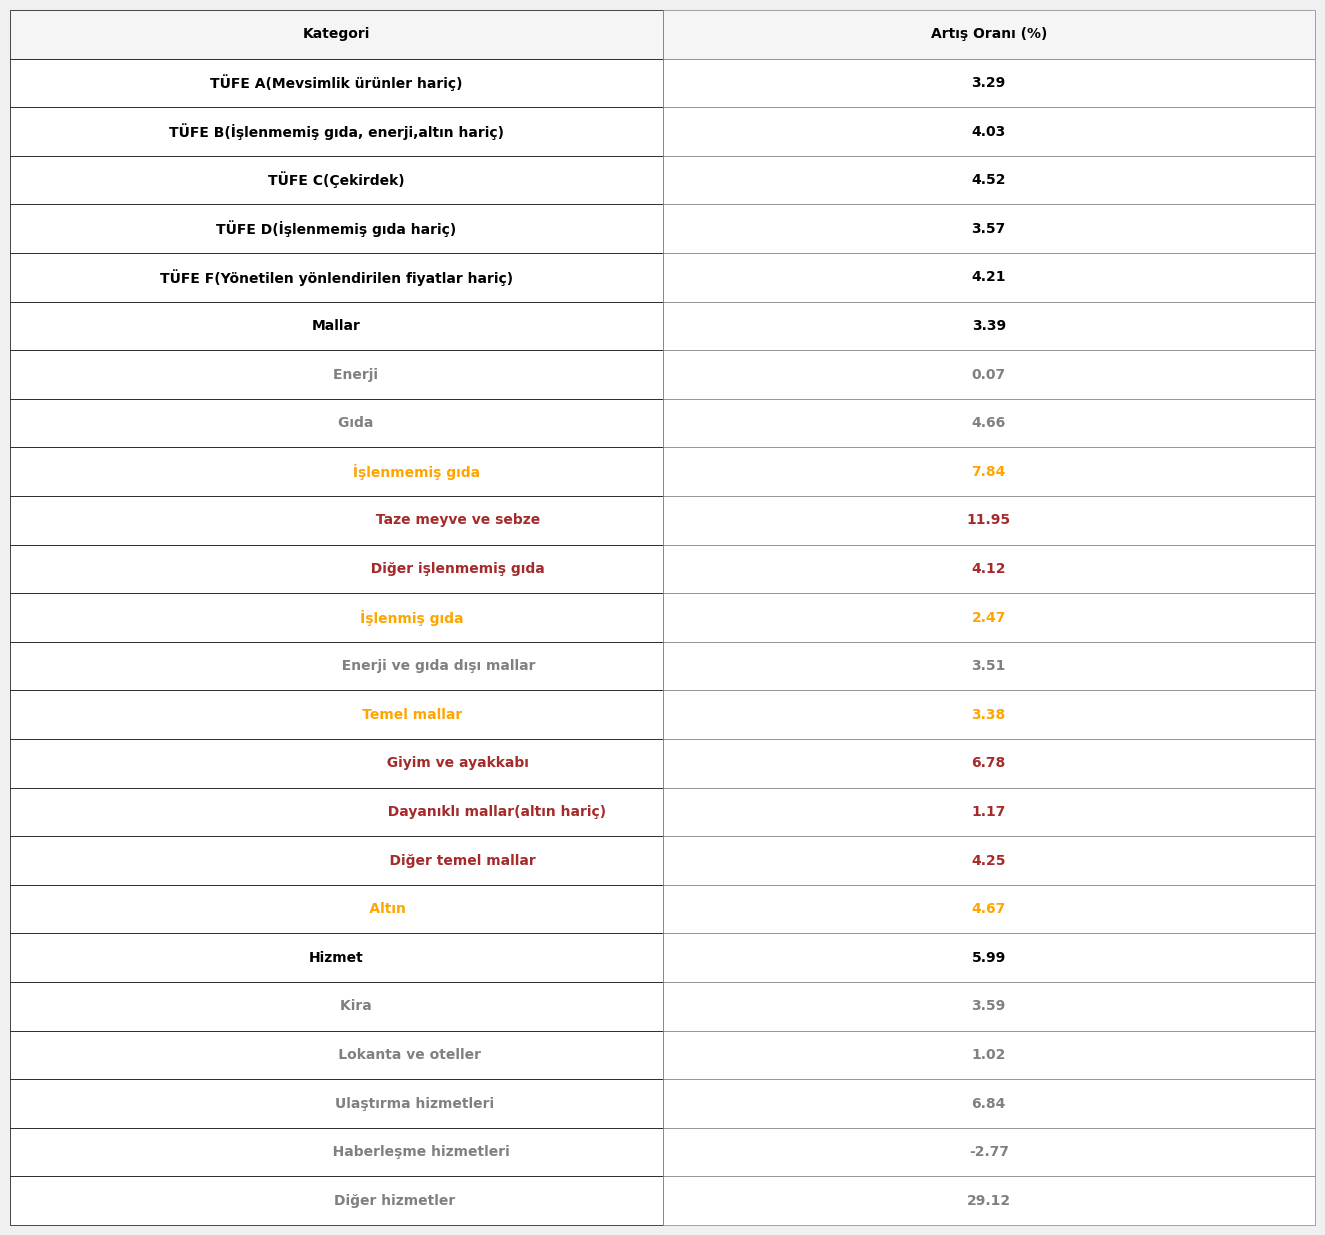

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
def artıshesapla(seri):
    artıs=(((özelgöstergeler[seri].loc["2025-03"].mean()/özelgöstergeler[seri].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
    artıs=artıs.round(2)
    return artıs
    
# Veriyi tanımlayalım
data = {
    "Kategori": [
        "TÜFE A(Mevsimlik ürünler hariç)",
        "TÜFE B(İşlenmemiş gıda, enerji,altın hariç)",
        "TÜFE C(Çekirdek)",
        "TÜFE D(İşlenmemiş gıda hariç)",
        "TÜFE F(Yönetilen yönlendirilen fiyatlar hariç)",
        "Mallar",
        "        Enerji",
        "        Gıda",
        "                                 İşlenmemiş gıda",
        "                                                  Taze meyve ve sebze",
        "                                                  Diğer işlenmemiş gıda",
        "                               İşlenmiş gıda",
        "                                          Enerji ve gıda dışı mallar",
        "                               Temel mallar",
        "                                                  Giyim ve ayakkabı",
        "                                                                  Dayanıklı mallar(altın hariç)",
        "                                                    Diğer temel mallar",
        "                     Altın",
        "Hizmet",
        "        Kira",
        "                              Lokanta ve oteller",
        "                                Ulaştırma hizmetleri",
        "                                   Haberleşme hizmetleri",
        "                        Diğer hizmetler"
    ],
    "Artış Oranı (%)": [artıshesapla("Mevsimlik Ürünler Hariç TÜFE"),artıshesapla("TÜFE B"),artıshesapla("TÜFE C"),artıshesapla("TÜFE D"),artıshesapla("TÜFE F"),
                        artıshesapla("Mallar"),artıshesapla("Enerji"),artıshesapla("Gıda ve alkolsüz içecekler"), artıshesapla("İşlenmemiş gıda"), artıshesapla("Taze meyve ve sebze")
                        , artıshesapla("Diğer işlenmemiş gıda"), artıshesapla("İşlenmiş Gıda"),artıshesapla("Enerji ve gıda dışı mallar"),artıshesapla("Temel mallar"),artıshesapla("Giyim ve ayakkabı"),
                        artıshesapla("Dayanıklı Mallar (altın hariç)"),artıshesapla("Diğer Temel Mallar"),artıshesapla("Alkollü içecekler, tütün ve altın"),
                        artıshesapla("Hizmet"),artıshesapla("Kira"),artıshesapla("Lokanta ve oteller"),artıshesapla("Ulaştırma hizmetleri"),artıshesapla("Haberleşme hizmetleri"),artıshesapla("Diğer hizmetler")],
}

# Veriyi DataFrame'e dönüştürelim
df = pd.DataFrame(data)

# Tabloyu göster
fig, ax = plt.subplots(figsize=(15, 12))
ax.axis('off')  # Tabloyu temiz bir şekilde göstermek için eksenleri kapat

# Tabloyu çiz
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)

# Tablo hücrelerine kenarlık ekleyerek hiyerarşiyi vurgulamak
for (i, j), cell in table.get_celld().items():
    cell.set_fontsize(35)
    if i == 0:
        cell.set_fontsize(35)
        cell.set_text_props(weight='bold')
        cell.set_fontsize(35)
    elif i==6 or i==19 or i==1 or i==2 or i==3 or i==4 or i==5:
        cell.set_text_props(color="black",weight='bold')
        cell.set_fontsize(35)
    elif i==7 or i==8 or i==13 or i==20 or i==21 or i==22 or i==23 or i==24 or i==25:
        cell.set_text_props(color="gray",weight='bold')
        cell.set_fontsize(25)
    elif i==9 or i==12 or i==14 or i==18:
        cell.set_text_props(color="orange",weight='bold')
        cell.set_fontsize(25)
    elif i==10 or i==11 or i==15 or i==16 or i==17:
        cell.set_text_props(color="brown",weight='bold')
        cell.set_fontsize(35)
    else:
        cell.set_fontsize(25)
    if j == 0:
        cell.set_edgecolor('black')  # Sadece sol kenarları belirginleştir
    else:
        cell.set_edgecolor('gray')  # Sağ kenarları daha hafif yapmak için

    cell.set_height(0.05)

# Grafik göster
plt.savefig("özelgöstergelerartış.png", dpi=300)


In [20]:
ağırlıklar=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
ağırlıklar=ağırlıklar.sort_values(by="Ağırlık",ascending=False)
ağırlıklar

,Ağırlık,Ana Grup,Endeks_2024-12-31,Endeks_2025-01-06,Endeks_2025-01-07,Endeks_2025-01-09,Endeks_2025-01-10,Endeks_2025-01-11,Endeks_2025-01-12,Endeks_2025-01-13,...,Endeks_2025-03-14,Endeks_2025-03-15,Endeks_2025-03-16,Endeks_2025-03-17,Endeks_2025-03-18,Endeks_2025-03-19,Endeks_2025-03-20,Endeks_2025-03-21,Endeks_2025-03-22,Endeks_2025-03-23
Ürün,,,,,,,,,,,,,,,,,,,,,
Kiracı Tarafından Ödenen Gerçek Kira,0.082368,Konut,100.0,100.781640,100.969082,101.146928,101.318383,101.480153,101.641082,101.801584,...,110.120614,110.310490,110.301768,110.464222,110.789129,110.951583,111.114036,111.114036,111.276253,111.276253
Otomobil (Benzinli),0.064684,Ulaştırma,100.0,100.000000,100.212640,100.328435,100.350229,100.747392,100.747392,100.747392,...,102.961798,102.961798,102.961798,102.961798,102.961798,102.961798,102.961798,102.961798,102.961798,102.961798
Ekmek,0.026524,Gıda ve alkolsüz içecekler,100.0,99.984778,100.274465,100.020779,100.020779,100.020779,100.020779,100.020779,...,108.378172,108.349002,108.362784,108.359243,108.484675,108.559904,108.547463,108.531319,108.138582,108.136625
Dana Eti,0.025460,Gıda ve alkolsüz içecekler,100.0,101.039015,101.222732,100.890431,100.387579,100.387579,100.343092,100.343092,...,108.806388,108.789981,108.808717,108.633854,109.260541,109.429981,109.497254,109.709782,109.934762,110.162770
Su Faturası,0.023802,Konut,100.0,124.565952,124.565952,124.565952,124.565952,124.565952,124.565952,124.565952,...,129.740155,129.740155,129.740155,129.740155,129.740155,129.740155,129.740155,129.740155,129.740155,129.740155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kakao,0.000059,Gıda ve alkolsüz içecekler,100.0,103.541273,103.541273,103.541273,103.541273,103.541273,103.541273,103.541273,...,116.637162,116.619437,116.627867,116.604566,116.681276,116.712623,116.705655,116.696613,116.196383,116.196383
Köprü Geçiş Ücreti,0.000057,Ulaştırma,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,133.549870,...,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940
Metro Ücreti,0.000036,Ulaştırma,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944


In [28]:
seçilmiş=list(ağırlıklar.index[:30].drop(["Kiracı Tarafından Ödenen Gerçek Kira","Ekmek","Dana Eti","Cep Telefonu Görüşme Ücreti",'Doğalgaz Ücreti', 'Elektrik Ücreti','Tavuk Eti','Kuzu Eti',
       'Ayçiçek Yağı','Çamaşır İçin Temizlik ve Bakım Ürünleri','Beyaz Peynir', "Yumurta","Domates"]).values)
seçilmiş.extend(["Televizyon","Özel İlköğretim Ücreti","Otel Ücreti","No-Frost Buzdolabı","Çamaşır Makinesi","Tüp Gaz Ücreti","Gündelikçi Ücreti","Motorsiklet","Yatak Odası Takımı","Erkek Berberi",
                 "Çorbalar","Spor Ayakkabısı (Erkek için)","Pizzalar","Kadın Berberi","Derin Dondurucu","Elektrikli Süpürge","Bulaşık Makinesi","Spor Ayakkabısı (Kadın için)","Tek Masa","Test Kitapları","Bilgisayar","Yemek Odası Takımı","Yatak (Çift Kişilik)","Sürücü Eğitim Kurs Ücreti","Ankastre Mikrodalga Fırın","Soğuk İçecekler (Servis edilen)","Telefon Onarım Ücreti","Bisiklet","Kaşık, Çatal, Bıçak Takımı (Çelik)","Kuru Temizleme Ücreti","Veteriner Ücreti","Tablet (Bilgisayar)","Ayakkabı Tamiri (Erkek)"])

In [30]:
from scipy.stats import gmean
sepet=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe/deneme.csv",index_col=0)
fiyatlar=pd.DataFrame()
fiyatlar["Madde"]=seçilmiş
def geometric_mean_log(series):
    # Veriyi logaritma alarak normalize et
    log_series = np.log(series)
    
    # Logaritmaların ortalamasını al ve sonrasında exponansiyelini al
    geo_mean = np.exp(log_series.mean())
    
    return geo_mean
for madde in seçilmiş:
    if isinstance(sepet.loc[madde,"2025-03-01":],pd.Series):
        fiyatlar.loc[fiyatlar["Madde"]==madde,"Fiyat"]=sepet.loc[madde,"2025-03-01":].mean()
    else:
        fiyatlar.loc[fiyatlar["Madde"]==madde,"Fiyat"]=sepet.loc[madde,"2025-03-01":].apply(geometric_mean_log,axis=0).mean()

C:\Users\Bora\AppData\Local\Temp\ipykernel_4172\1259419946.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  sepet=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe/deneme.csv",index_col=0)


In [31]:

fiyatlar["Fiyat"]=fiyatlar["Fiyat"].round(2)
fiyatlar

,Madde,Fiyat
0,Otomobil (Benzinli),2491183.08
1,Su Faturası,36.90
2,Motorin,45.37
3,"Hazır Yemekler (Pilav, Kuru Fasulye)",123.89
4,Sıcak İçecekler (Servis edilen),200.16
5,Ekmekarası Yiyecekler (Döner),232.42
6,Benzin,44.83
7,Telefon Ekipmanları (Cep Telefonu),13116.89
8,Burgerler,219.69
9,Otomobil (Elektrikli),2491183.08


In [32]:
fiyatlar=fiyatlar.sort_values(by="Fiyat",ascending=True)


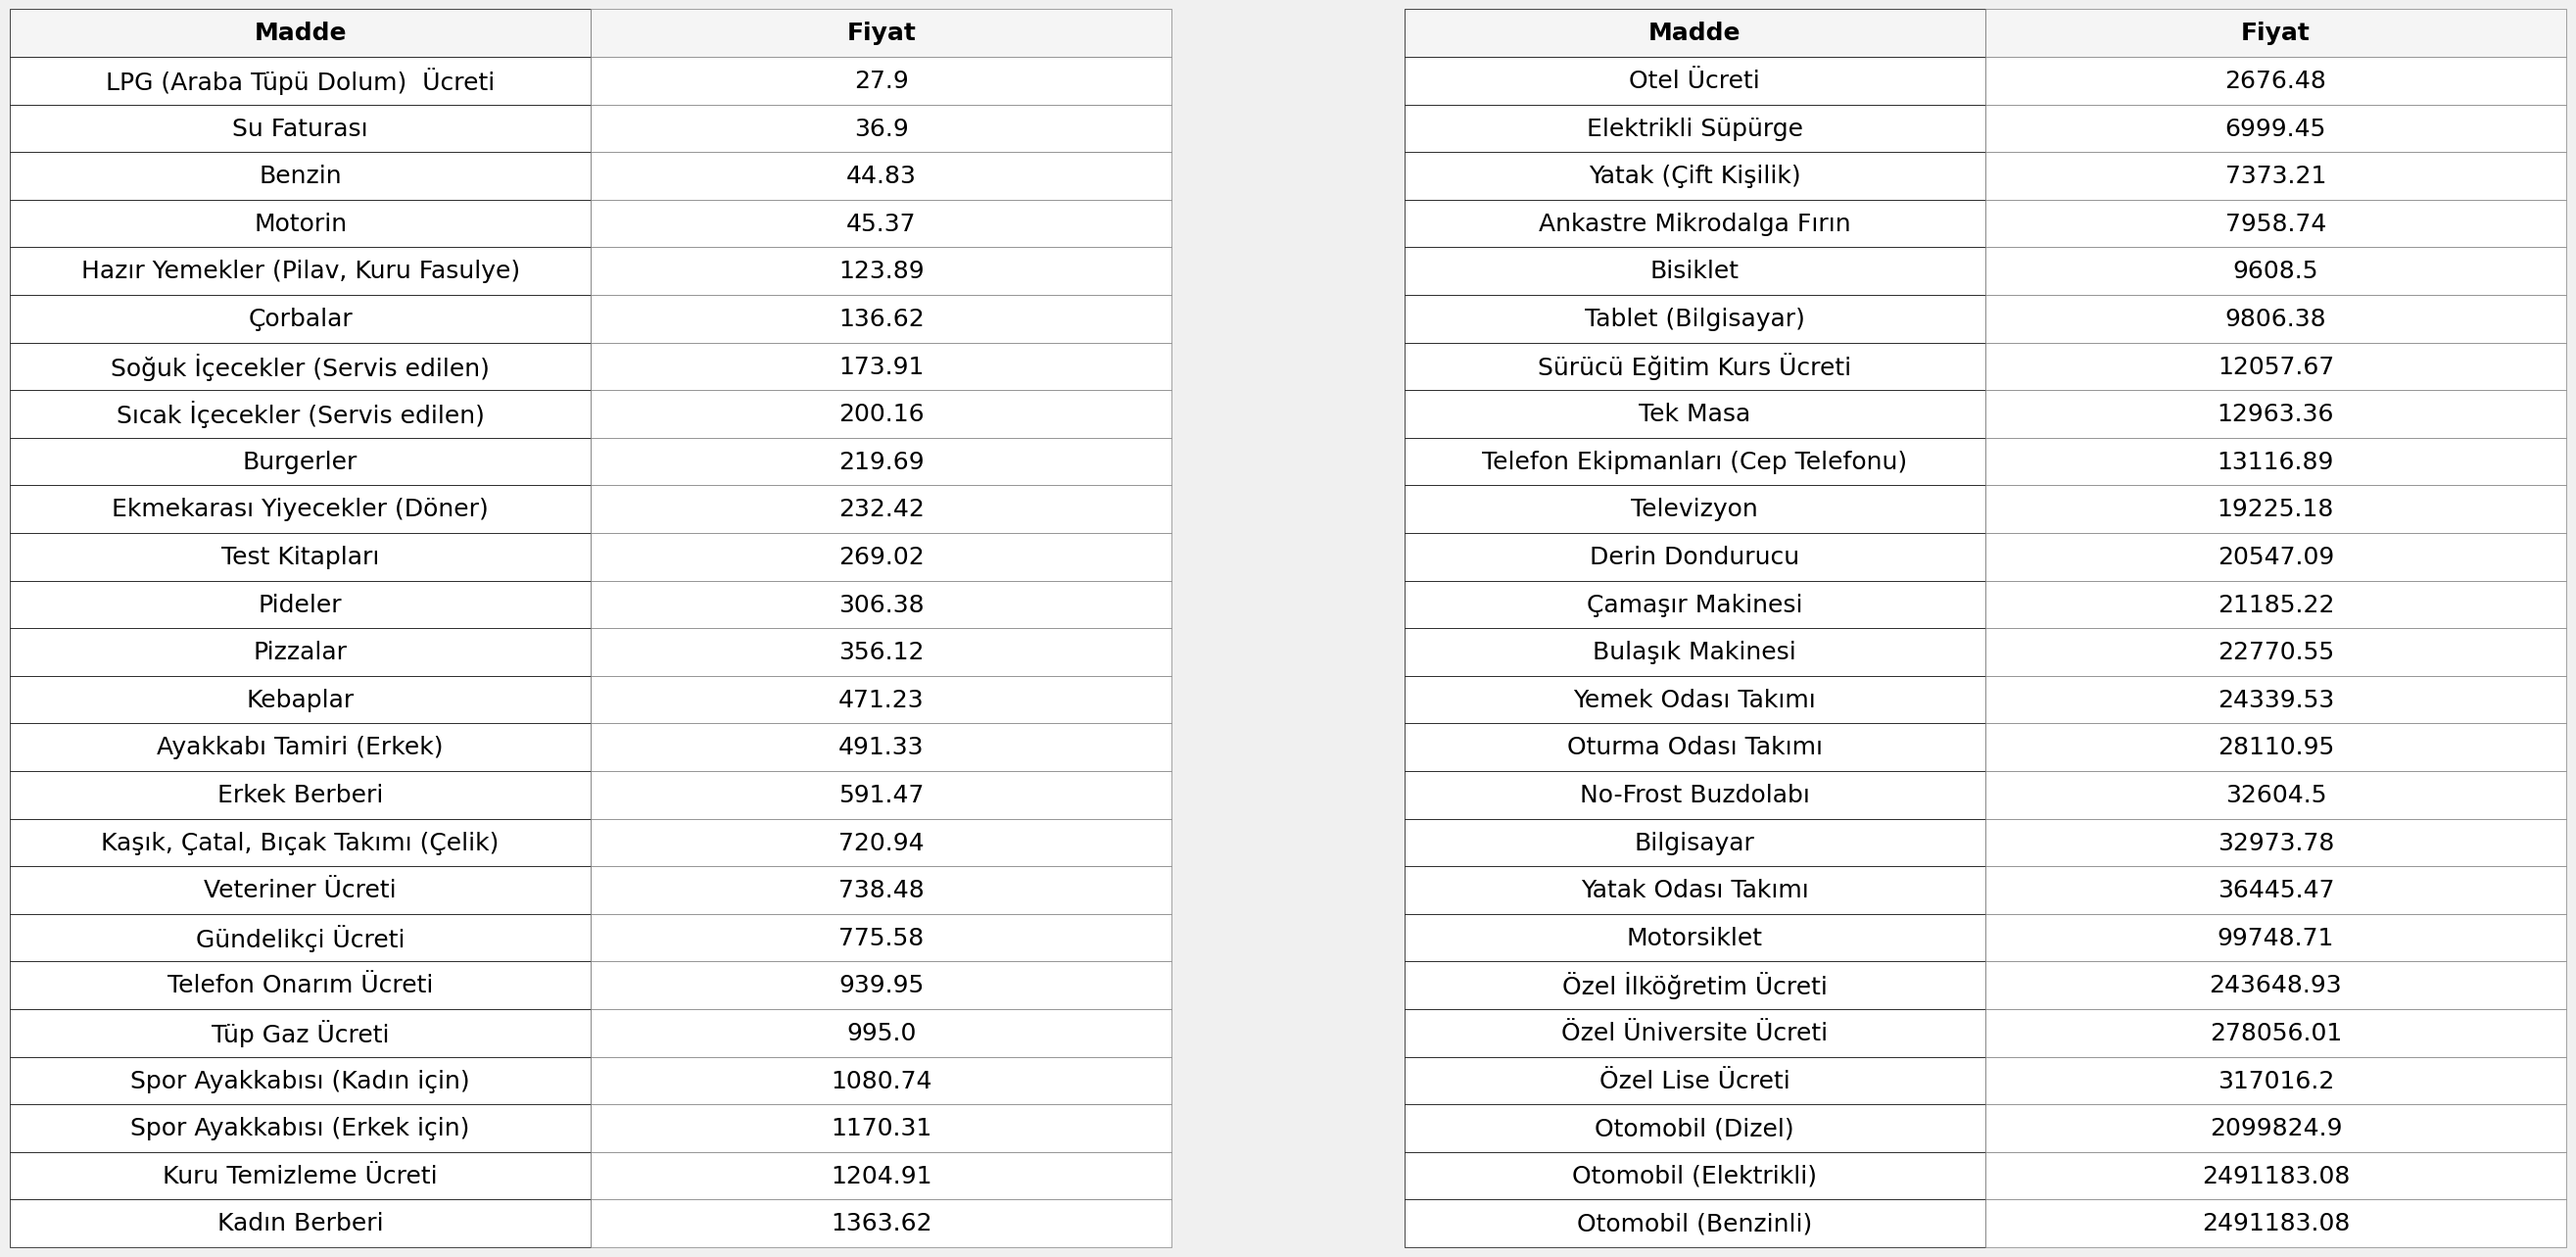

In [33]:
import matplotlib.pyplot as plt

# Veri örneği (fiyatlar yerine gerçek verinizi kullanmalısınız)
# fiyatlar = ...

# Tabloyu 2 parçaya bölelim
half = len(fiyatlar) // 2

# Grafik ve eksenleri oluştur
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))  # Yan yana 2 alt grafik

# İlk yarı
ax1.axis('off')  # Eksenleri kapat
table1 = ax1.table(cellText=fiyatlar.iloc[:half].values, colLabels=fiyatlar.columns, loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)

for (i, j), cell in table1.get_celld().items():
    if i == 0:
        cell.set_fontsize(18)
        cell.set_text_props(weight='bold')
    else:
        cell.set_fontsize(18)
    if j == 0:
        cell.set_edgecolor('black')
    else:
        cell.set_edgecolor('gray')
    cell.set_height(0.05)

# İkinci yarı
ax2.axis('off')  # Eksenleri kapat
table2 = ax2.table(cellText=fiyatlar.iloc[half:].values, colLabels=fiyatlar.columns, loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)

for (i, j), cell in table2.get_celld().items():
    if i == 0:
        cell.set_fontsize(18)
        cell.set_text_props(weight='bold')
    else:
        cell.set_fontsize(18)
    if j == 0:
        cell.set_edgecolor('black')
    else:
        cell.set_edgecolor('gray')
    cell.set_height(0.05)

# Grafik göster
plt.savefig("fiyatlar.png", dpi=300)



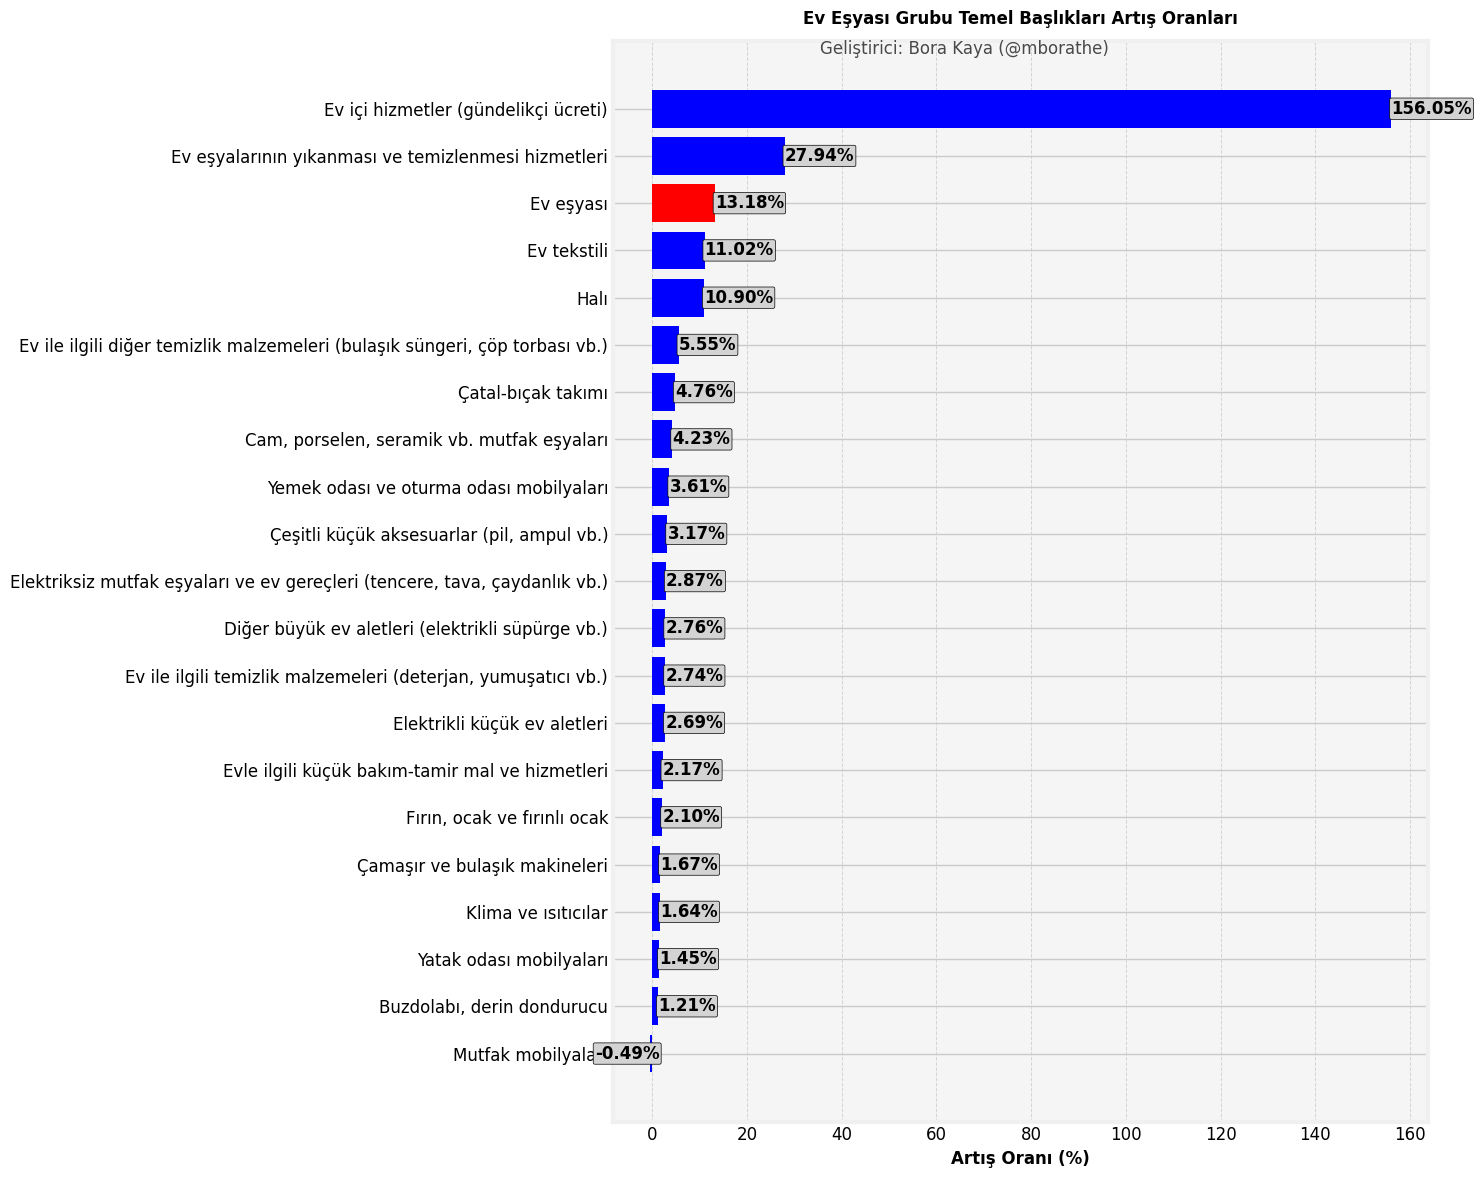

In [37]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]=="Ev eşyası"]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-03"].mean()/harcama_grupları[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc["Ev eşyası"]=(((gruplar["Ev eşyası"].loc["2025-03"].mean()/gruplar["Ev eşyası"].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == 'Ev eşyası' else 'blue' for label in artıslar.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in artıslar.index]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Ev Eşyası Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.65, 0.95, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"eveşyası.png", dpi=300)


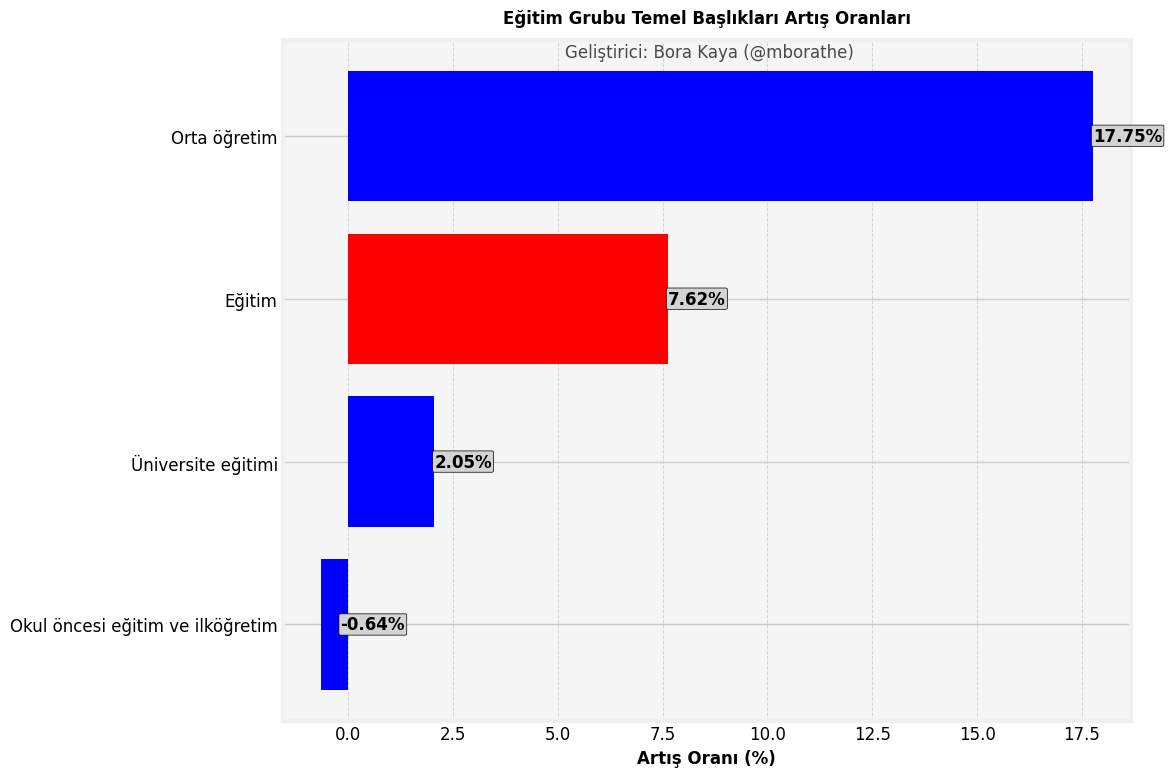

In [38]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]=="Eğitim"]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-03"].mean()/harcama_grupları[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc["Eğitim"]=(((gruplar["Eğitim"].loc["2025-03"].mean()/gruplar["Eğitim"].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == 'Eğitim' else 'blue' for label in artıslar.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in artıslar.index]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Eğitim Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.60, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"eğitim.png", dpi=300)


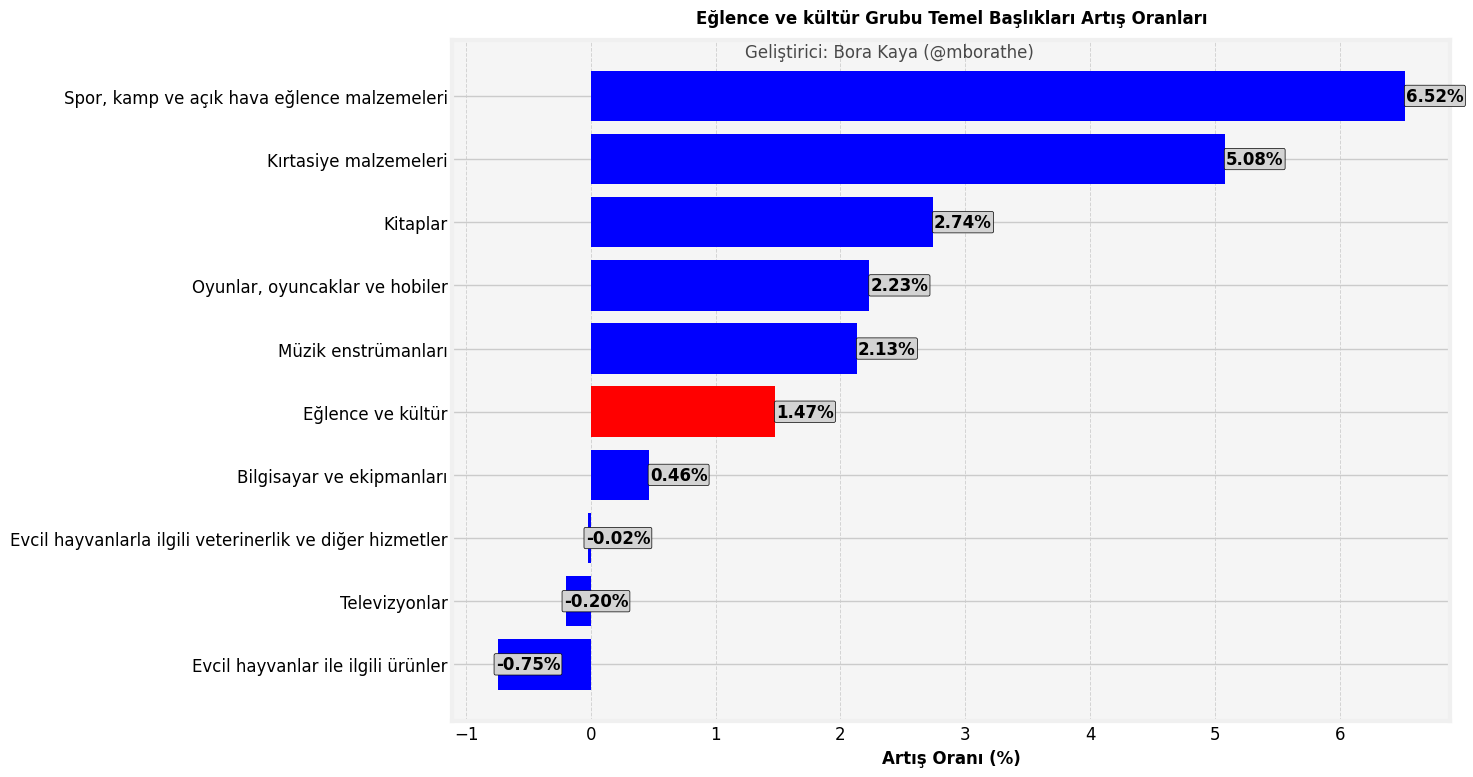

In [40]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Eğlence ve kültür"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-03"].mean()/harcama_grupları[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-03"].mean()/gruplar[ana].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in artıslar.index]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.60, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"eğlence.png", dpi=300)


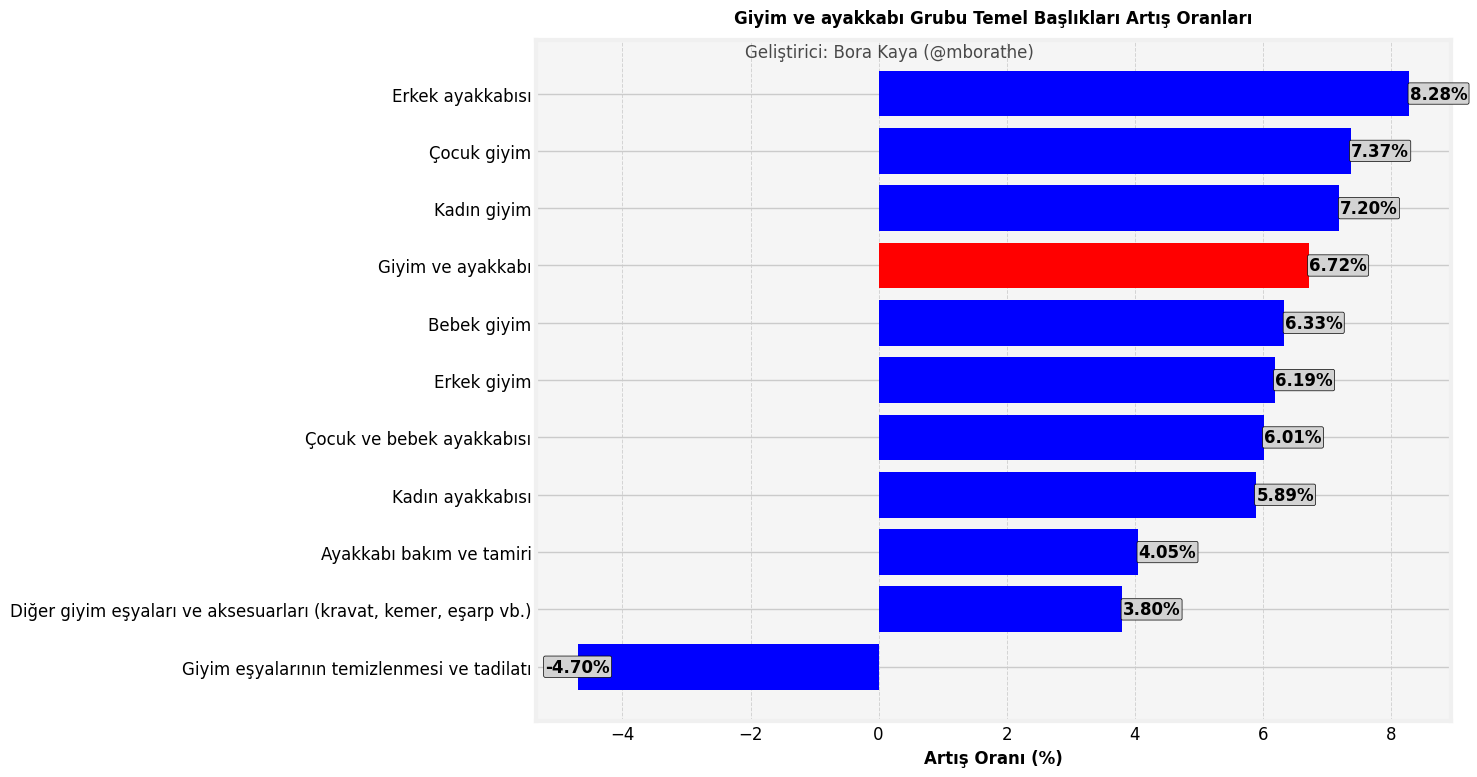

In [43]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Giyim ve ayakkabı"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-03"].mean()/harcama_grupları[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-03"].mean()/gruplar[ana].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in artıslar.index]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.60, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


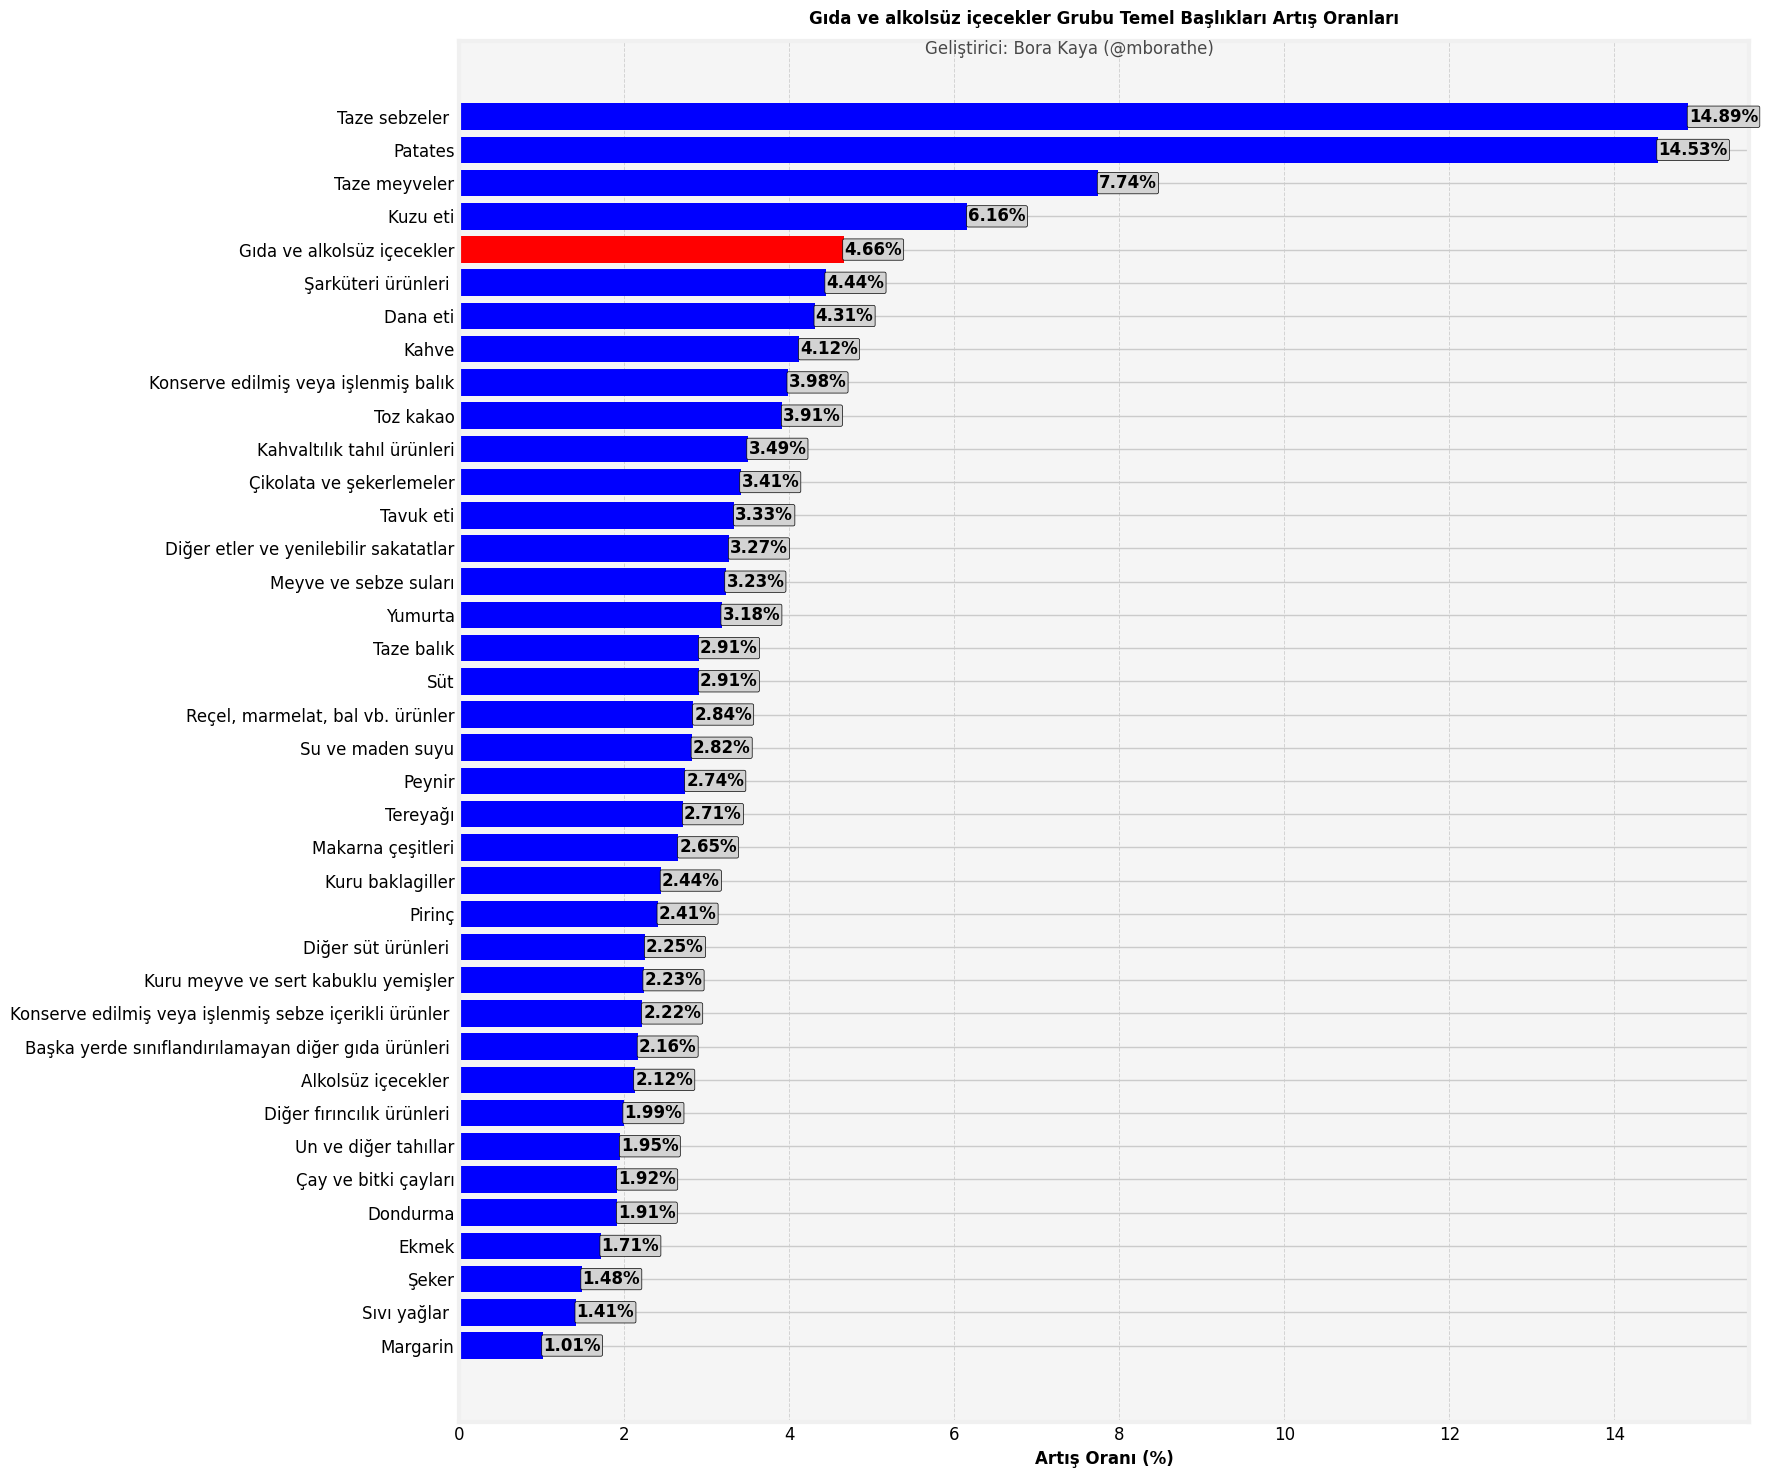

In [44]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Gıda ve alkolsüz içecekler"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-03"].mean()/harcama_grupları[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-03"].mean()/gruplar[ana].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [
    label.split('(')[0] if '(' in label else label[:60]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 15))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.96, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


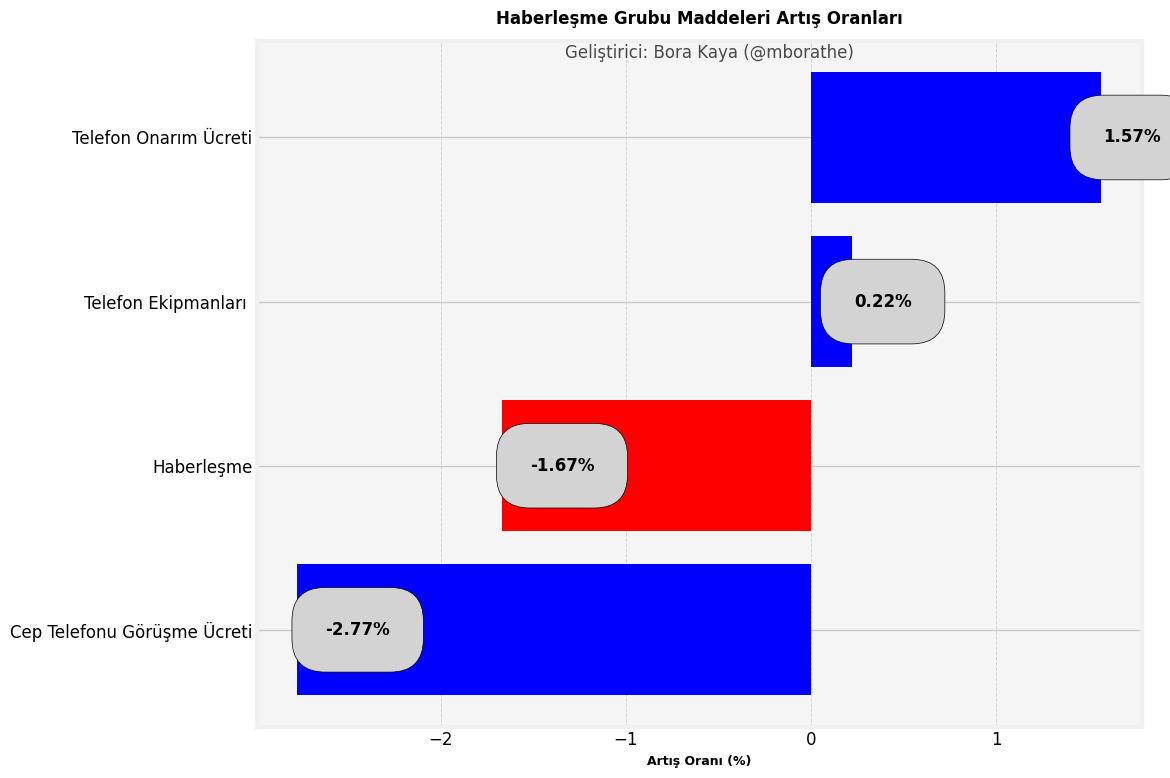

In [45]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Haberleşme"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Ürün"].unique()
artıslar=(((endeksler[grup].loc["2025-03"].mean()/endeksler[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-03"].mean()/gruplar[ana].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [
    label.split('(')[0] if '(' in label else label[:60]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=2')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Maddeleri Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=9, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


In [47]:
harcama_grupları=harcama_grupları.round(2)
endeksler=endeksler.round(2)

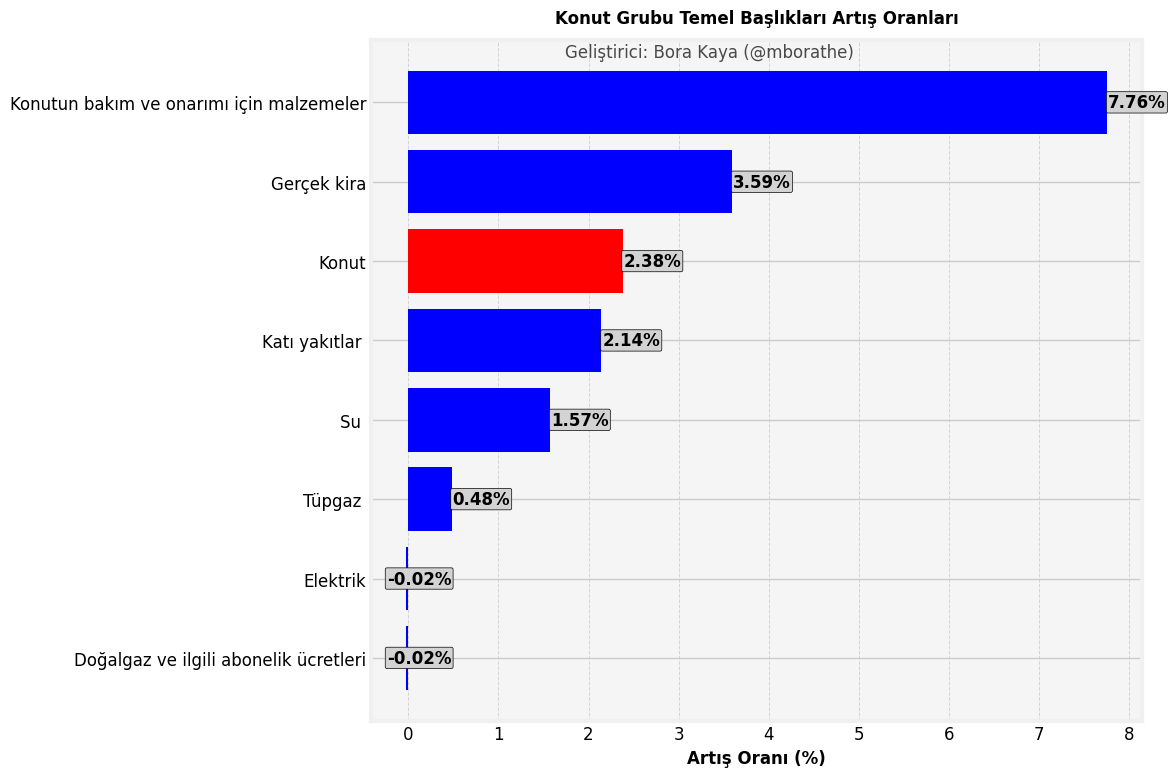

In [48]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Konut"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-03"].mean()/harcama_grupları[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-03"].mean()/gruplar[ana].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [
    label.split('(')[0] if '(' in label else label[:60]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


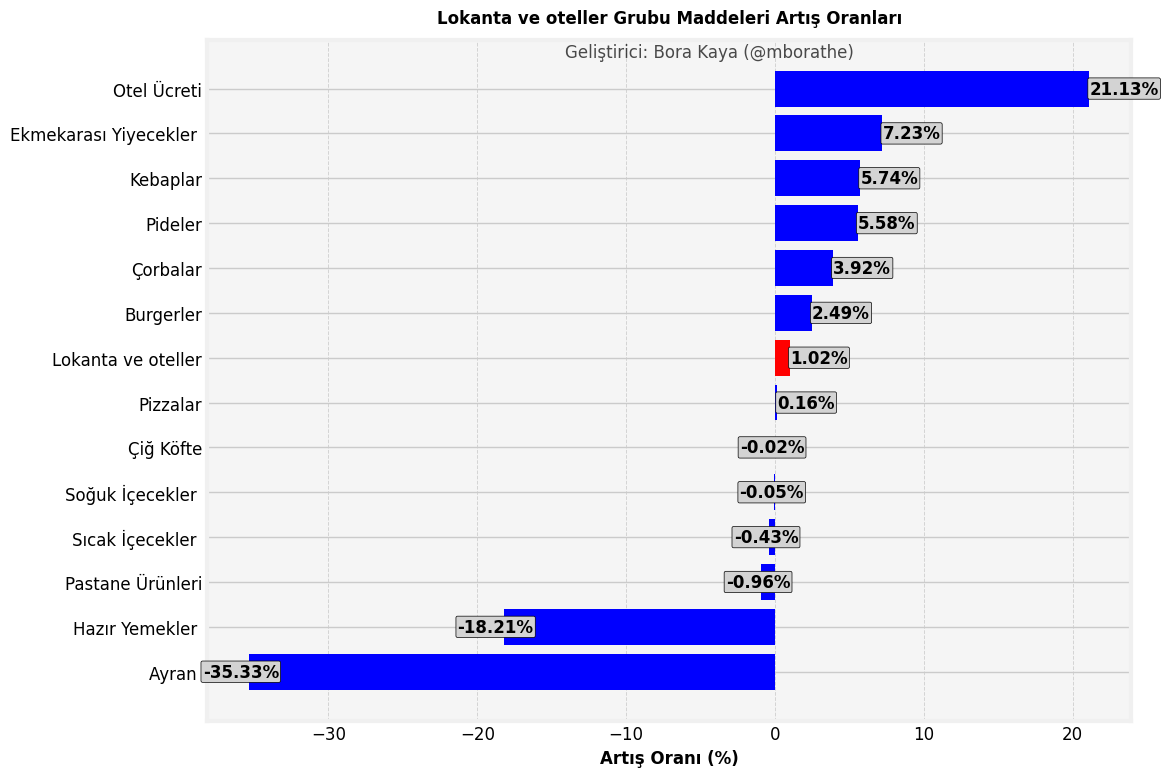

In [52]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Lokanta ve oteller"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Ürün"].unique()
artıslar=(((endeksler[grup].loc["2025-03"].mean()/endeksler[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-03"].mean()/gruplar[ana].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [
    label.split('(')[0] if '(' in label else label[:60]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Maddeleri Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


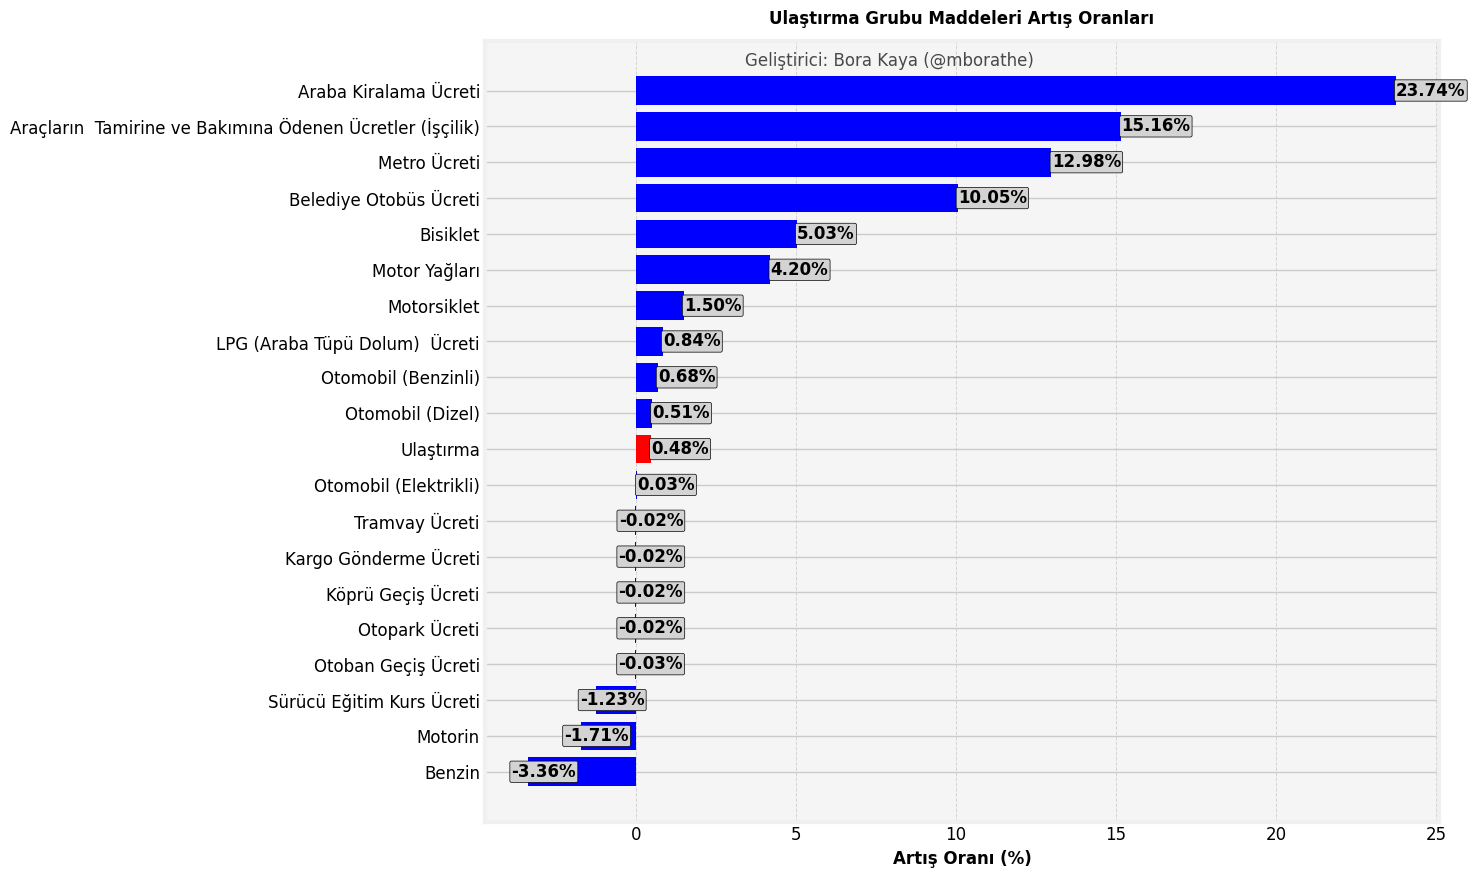

In [53]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Ulaştırma"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Ürün"].unique()
artıslar=(((endeksler[grup].loc["2025-03"].mean()/endeksler[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-03"].mean()/gruplar[ana].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [label[:80]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value > 0 else xpos +1.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Maddeleri Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


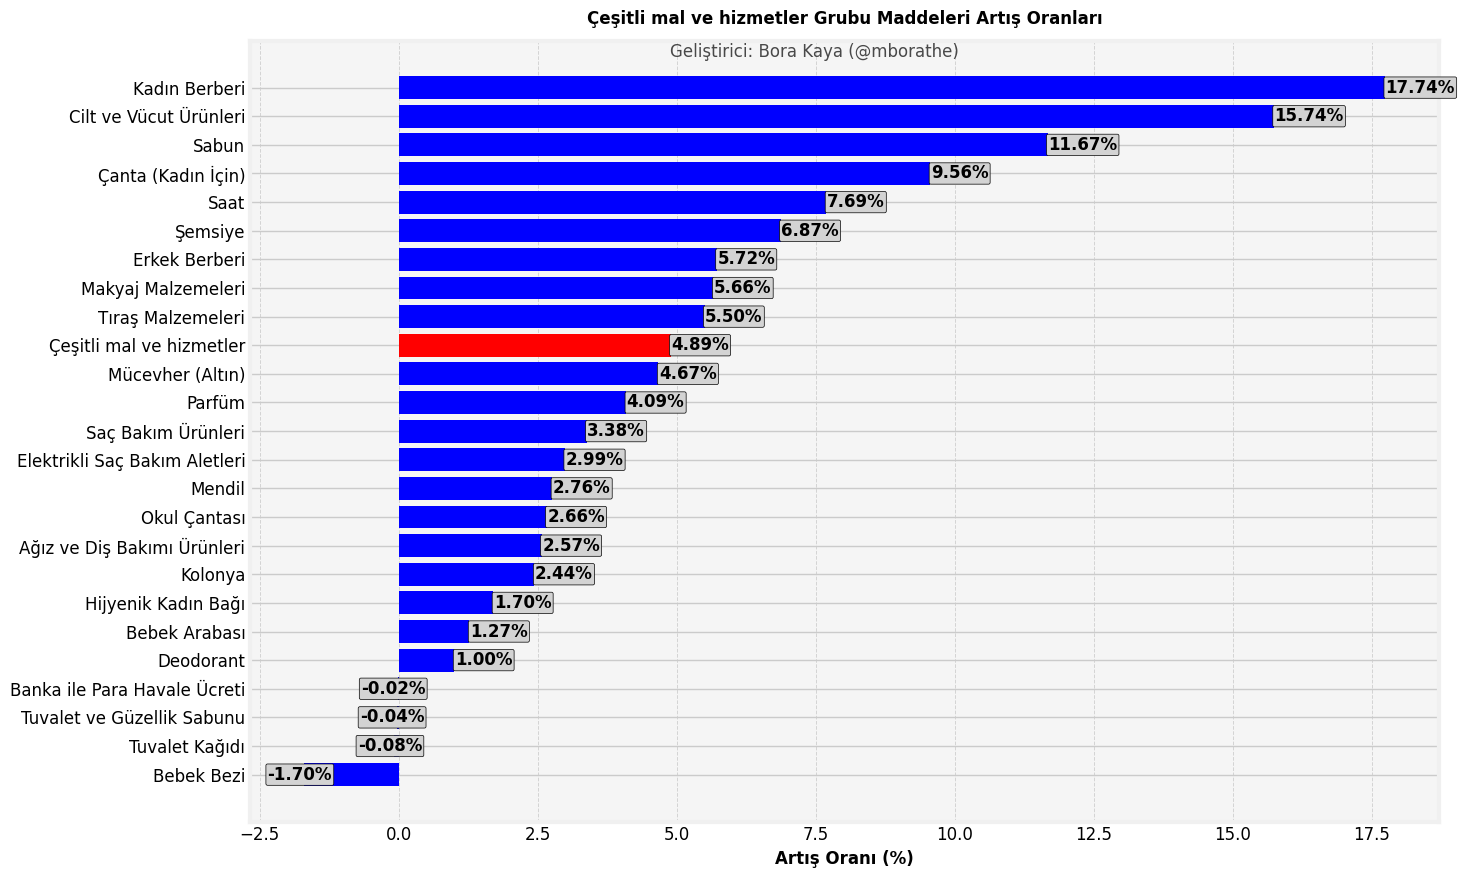

In [54]:

harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Çeşitli mal ve hizmetler"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Ürün"].unique()
artıslar=(((endeksler[grup].loc["2025-03"].mean()/endeksler[grup].loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-03"].mean()/gruplar[ana].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]
artıslar=artıslar.round(2)
artıslar.loc[artıslar == -0.01] = 0.0
# Modify the index shortening logic
shortened_index = [label[:80]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value > 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Maddeleri Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.55, 0.93, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


In [68]:
import os
import random
import numpy as np
import pandas as pd
from statsmodels.tsa.x13 import x13_arima_analysis

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)



# Set the path to the X13-ARIMA executable
x13_path = r'C:\Users\Bora\Desktop\x13as'
spec = """
outlier {
    method = addone;
    types = ao tc ls;
}
"""


datasa = pd.DataFrame()
for col in data.columns:
    try:
            ayris = x13_arima_analysis(data[col], x12path=x13_path,outlier=False)
            datasa[col] = ayris.seasadj
    except Exception as e:
            datasa[col] = data[col]



c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\x13.py:192: X13Warning: 

In [69]:
medyan=datasa.pct_change().iloc[-1].sort_values().median()*100

In [70]:
harcamağırlık=harcamaürünleri[harcamaürünleri["Grup"].isin(datasa.columns)].groupby("Grup")["Ağırlık"].sum()/harcamaürünleri[harcamaürünleri["Grup"].isin(datasa.columns)].groupby("Grup")["Ağırlık"].sum().sum()

In [71]:
datasa_aylık=datasa.pct_change().iloc[-1:]*100

for row in datasa_aylık.index:
    ay=datasa_aylık.loc[row]
    ay=ay.sort_values(ascending=False).iloc[int(len(datasa_aylık.columns)*0.15):int(-len(datasa_aylık.columns)*0.15)]
    ay=ay.sort_index()
    harcamağırlık=harcamağırlık.loc[(ay.index.values)]
    harcamağırlık=(harcamağırlık/harcamağırlık.sum())
    satrim=(np.sum(ay.values*harcamağırlık))


In [72]:
harcamağırlık=harcamaürünleri[harcamaürünleri["Grup"].isin(datasa.columns)].groupby("Grup")["Ağırlık"].sum()/harcamaürünleri[harcamaürünleri["Grup"].isin(datasa.columns)].groupby("Grup")["Ağırlık"].sum().sum()
satüfe=(datasa_aylık.iloc[-1]*harcamağırlık).sum()

In [73]:
tüfe_b_excluded=["Dana eti","Kuzu eti","Tavuk eti","Diğer etler ve yenilebilir sakatatlar","Taze balık","Konserve edilmiş veya işlenmiş balık","Yumurta","Taze meyveler","Taze sebzeler (patates hariç)",
                 "Elektrik","Doğalgaz ve ilgili abonelik ücretleri","Tüpgaz (ev tüpü)","Katı yakıtlar (odun, kömür)",
                 "Kişisel ulaştırma araçlarının yakıt ve yağları (benzin, motorin, motor yağı)","Mücevheratlar, saat ve kol saatleri","Üniversite eğitimi"]
tüfe_b=harcamaürünleri[~harcamaürünleri["Grup"].isin(tüfe_b_excluded)].drop_duplicates()

tüfe_b_sa=(datasa_aylık[tüfe_b["Grup"].unique()].iloc[-1]*tüfe_b.groupby("Grup")["Ağırlık"].sum()/tüfe_b.groupby("Grup")["Ağırlık"].sum().sum()).sum()

In [74]:
tüfe_c_excluded=[
                 "Elektrik","Doğalgaz ve ilgili abonelik ücretleri","Tüpgaz (ev tüpü)","Katı yakıtlar (odun, kömür)",
                 "Kişisel ulaştırma araçlarının yakıt ve yağları (benzin, motorin, motor yağı)","Mücevheratlar, saat ve kol saatleri",
                 'Alkolsüz içecekler (meşrubat, ayran vb.)',
       'Başka yerde sınıflandırılamayan diğer gıda ürünleri (tuz, kabartma maddeleri, sirke, ketçap, mayonez vb.)',
       'Dana eti', 'Diğer etler ve yenilebilir sakatatlar',
       'Diğer fırıncılık ürünleri (bisküvi, kek, kraker, yufka, baklava vb.)',
       'Diğer süt ürünleri (yoğurt, hazır sütlü tatlı vb.)', 'Dondurma',
       'Ekmek', 'Kahvaltılık tahıl ürünleri', 'Kahve',
       'Konserve edilmiş veya işlenmiş balık',
       'Konserve edilmiş veya işlenmiş sebze içerikli ürünler (salça, turşu, zeytin vb. dahil)',
       'Kuru baklagiller', 'Kuru meyve ve sert kabuklu yemişler',
       'Kuzu eti', 'Makarna çeşitleri', 'Margarin',
       'Meyve ve sebze suları', 'Patates', 'Peynir', 'Pirinç',
       'Reçel, marmelat, bal vb. ürünler', 'Su ve maden suyu', 'Süt',
       'Sıvı yağlar (zeytinyağı, ayçiçek yağı)', 'Tavuk eti',
       'Taze balık', 'Taze meyveler', 'Taze sebzeler (patates hariç)',
       'Tereyağı', 'Toz kakao', 'Un ve diğer tahıllar', 'Yumurta',
       'Çay ve bitki çayları', 'Çikolata ve şekerlemeler',
       'Şarküteri ürünleri (sucuk, sosis, salam vb.)', 'Şeker',"Üniversite eğitimi"]
tüfe_c=harcamaürünleri[~harcamaürünleri["Grup"].isin(tüfe_c_excluded)].drop_duplicates()
tüfe_c["Ağırlık"]=tüfe_c["Ağırlık"]/tüfe_c["Ağırlık"].sum()
tüfe_c=tüfe_c.drop_duplicates()

tüfe_c_sa=(datasa_aylık[tüfe_c["Grup"].unique()].iloc[-1]*tüfe_c.groupby("Grup")["Ağırlık"].sum()/tüfe_c.groupby("Grup")["Ağırlık"].sum().sum()).sum()

In [75]:
eğilim=pd.DataFrame()
eğilim["TÜFE"]=[satüfe]
eğilim["TÜFE B"]=[tüfe_b_sa]
eğilim["TÜFE C"]=[tüfe_c_sa]
eğilim["Medyan"]=[medyan]
eğilim["SATRIM"]=[satrim]
eğilim=eğilim.T
eğilim=eğilim.sort_values(by=0)
eğilim

,0
Medyan,3.204493
SATRIM,3.465331
TÜFE B,4.000509
TÜFE,4.200399
TÜFE C,4.213607


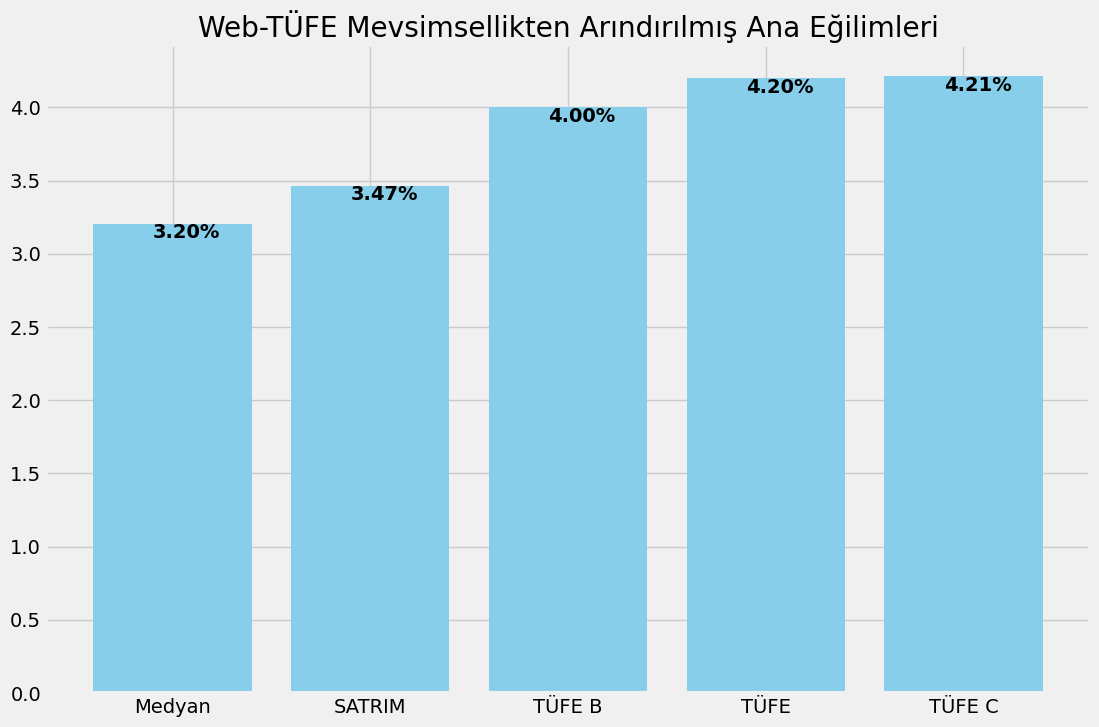

In [76]:
plt.figure(figsize=(12, 8))
plt.title("Web-TÜFE Mevsimsellikten Arındırılmış Ana Eğilimleri")
plt.bar(eğilim.sort_values(by=0).index, eğilim.sort_values(by=0)[0], color='skyblue')
for i, v in enumerate(eğilim.sort_values(by=0)[0]):
    plt.text(i - 0.1, v - 0.1, f'{v:.2f}%', color='black', fontweight='bold')
plt.savefig("eğilim.png", dpi=300)


In [77]:
ağırlıklar=pd.read_csv("ağırlıklartüfe.csv",index_col=0)


ağırlıklar

,Ağırlık,Ana Grup,Endeks_2024-12-31,Endeks_2025-01-06,Endeks_2025-01-07,Endeks_2025-01-09,Endeks_2025-01-10,Endeks_2025-01-11,Endeks_2025-01-12,Endeks_2025-01-13,...,Endeks_2025-03-14,Endeks_2025-03-15,Endeks_2025-03-16,Endeks_2025-03-17,Endeks_2025-03-18,Endeks_2025-03-19,Endeks_2025-03-20,Endeks_2025-03-21,Endeks_2025-03-22,Endeks_2025-03-23
Ürün,,,,,,,,,,,,,,,,,,,,,
Ampul,0.000802,Ev eşyası,100.0,100.0000,99.999251,99.997889,99.987679,99.987679,99.988179,99.992993,...,107.967956,107.967956,108.104968,107.936280,108.369716,108.460426,108.442194,108.460181,108.584736,108.541724
Ankastre Fırın,0.000327,Ev eşyası,100.0,100.0000,100.000313,100.163323,100.175236,100.163661,100.163661,100.168927,...,104.247288,104.247288,104.265062,104.606847,104.843076,104.829543,105.023386,104.813608,104.832947,104.852253
Ankastre Mikrodalga Fırın,0.000879,Ev eşyası,100.0,100.0000,99.996850,99.998680,99.978380,99.926064,99.857056,99.849975,...,103.937042,103.726384,103.844364,103.898515,104.498800,104.372383,104.340416,104.280669,104.421999,104.365148
Ankastre Ocak (Set Üstü),0.000624,Ev eşyası,100.0,100.0000,100.001282,100.054694,100.054694,100.050235,100.061443,100.110973,...,104.283821,104.204175,104.328600,104.519005,104.680388,104.426679,104.533949,104.432644,104.634767,104.571407
Antep Fıstığı,0.000561,Gıda ve alkolsüz içecekler,100.0,103.0003,103.000300,103.000300,103.000300,103.000300,103.000300,103.000300,...,102.615247,103.403965,103.409749,103.393762,103.446396,103.469856,103.464642,104.843648,103.866490,103.866490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
İç Çamaşırı (Kadın için),0.002371,Giyim ve ayakkabı,100.0,100.0000,100.014876,100.020259,100.014941,100.023118,100.000140,100.001810,...,117.799431,118.230311,118.296184,118.410485,120.320064,120.784082,120.499943,120.499943,119.920950,120.015955
İç çamaşırı (Çocuk için),0.000520,Giyim ve ayakkabı,100.0,100.0000,100.000000,100.017980,100.014377,100.013454,100.013166,100.013166,...,105.199497,105.216745,105.155947,105.098288,105.330639,105.957479,105.972244,105.972244,105.900672,105.756171
Şeftali,0.001026,Gıda ve alkolsüz içecekler,100.0,100.0000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,106.267139,106.179664,106.221242,106.106288,106.484392,106.653438,106.615812,106.566999,106.354806,106.353754
